# Load Functions

In [1]:
library(Signac)
library(Seurat)
library(glue)
library(EnsDb.Mmusculus.v79)
library(ggsci)
library(ComplexHeatmap)
base_dir='./placeholder_project/code/'
CodePath = glue('{base_dir}/ATAC_pipeline_zyr/Code/')
source(file.path(CodePath,'Function/PipelineFuncHtml.R'))
source(file.path(CodePath,'Function/LoadsingleSample.func.R'))
source(file.path(CodePath,'Function/MotifAnalysis.func.R'))
source(file.path(CodePath,'Function/Signac.Heatmap.R'))
source(file.path(CodePath,'Function/ClusterAndTypeing.func.R'))
source(file.path(CodePath,'Function/cCREsStatistics.func.R'))
source(file.path(CodePath,'Function/Signac.Heatmap.R'))
source(file.path(CodePath,'Function/MergeSampleObj.R'))
source(file.path(CodePath,'Function/PredictCellType.R'))

setwd('./placeholder_project/code/')
source('./placeholder_project/code/jupyter_R/myFun.R')
source('./placeholder_project/code/jupyter_R/markerlist.R')
my_process_srt <- function(object, assay){
  DefaultAssay(object) <- assay
  object <- RunTFIDF(object)
  object <- FindTopFeatures(object, min.cutoff = 'q5',verbose = F)
  object <- RunSVD(object,verbose = F)
  object <- RunUMAP(object = object, reduction = 'lsi', dims = 2:30)
  object <- FindNeighbors(object = object, reduction = 'lsi', dims = 2:30 )
  object <- FindClusters(object = object, verbose = FALSE, algorithm = 3)
  return(object)
}
myRowScale<-function(m = NULL, min = -2, max = 2, limit = FALSE){
    z <- sweep(m - rowMeans(m), 1, matrixStats::rowSds(m),`/`)
    if(limit){
        z[z > max] <- max
        z[z < min] <- min
    }
    return(z)
}
myAveragePeak <- function(object,groupby, assay=NULL, slot = 'data'){
    if(!is.null(assay)){
        DefaultAssay(object) = assay
    }else{
        assay = DefaultAssay(object)
    }
    Idents(object) = object@meta.data[[groupby]]
    clusters =  unique(Idents(object))
    mat =  GetAssayData(object,assay = assay, slot)
    
    j = 1
    for (i in clusters) {
        #i = clusters[2]
        subBarcode = WhichCells(object = object,idents = i)
        sub_mat = mat[,subBarcode,drop=F] 
        mean.c = rowMeans(sub_mat)
        if(is.numeric(i)){
            Clu = paste0('C',i)
        }else{
            Clu = i
        }
       
        if (j == 1) {
            eval(parse(text = paste0('mean.mat = data.frame(`',Clu,'`= mean.c)')))
        }else{
            mean.mat[,Clu] = mean.c
        }
        j = j+1
    }
    return(mean.mat)
}
base_path='./placeholder_analysis/round_cluster02/cCRE/'

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading

In [2]:
pt_to_mm <- function(pt) {
  pt /2.13
}
label_size <-function(x){
    x/2.8453
}
mytheme =     theme_void()+
      theme(panel.border = element_rect(linewidth=pt_to_mm(0.25),fill=NA),
            plot.title = element_text(hjust = 0.5,face = "plain", size=8, margin = margin(t = 0, r = 0, b = 2, l = 0, unit = "pt")),

            axis.title = element_text(size=7),
            axis.title.y= element_text(angle = 90,hjust=0.5, margin = margin(t = 0, r = 2, b = 0, l = 0, unit = "pt")),
            axis.title.x= element_text(margin = margin(t = 2, r = 0, b = 0, l = 0, unit = "pt")),

            axis.text = element_text(size=6),
            axis.text.x = element_text(margin = margin(t = 1, r = 0, b = 0, l = 0, unit = "pt")),
            axis.text.y = element_text(margin = margin(t = 0, r = 1, b = 0, l = 0, unit = "pt")),

            axis.ticks = element_line(size = pt_to_mm(0.2)),
            axis.ticks.length =  unit(1, 'pt'),
            
            legend.spacing = unit(2, 'pt'),
            legend.key.width = unit(3, "mm"),  # Legend color bar width
            legend.key.height = unit(3, "mm"),    # Legend color bar height
            legend.key.spacing = unit(2, 'pt'),
            
            legend.text = element_text(size=6),
            legend.title = element_text(size=6,face = "plain"),
            legend.margin = margin(0, 0, 0, 0)
            )

In [3]:
family_abbr = c(    
    # Domain class
    "bHLH-ZIP"= "bHLH",
    "bHLH-ZIP::Ets-related"= "bHLH",
    "CREB-related factors"= "CREB",
    "CP2-related factors"= "CP2",
    "CEBP-related"= "CEBP",
    "FOX"= "FOX",
    "FOX::Ets-related"= "FOX",
    "Ets-related"= "ETS",
    "Ets-related::HOX-related factors"= "ETS",
    "Ets-related::bHLH-ZIP"= "ETS",
    "Ets-related::Tal-related"= "ETS",
    "Ets-related::FOX"= "ETS",
    "Fos-related"= "FOS",
    "Fos-related::Jun-related"= "FOS",
    "Jun-related"= "JUN",
    "Jun-related::Maf-related"= "JUN",
    "Maf-related"= "MAF",
    "Maf-related::Jun-related"= "MAF",
    "ATF-4-related factors"= "ATF",
    "B-ATF-related factors"= "BATF",
    "B-ATF-related factors::Jun-related"= "BATF",
    "STAT factors"= "STAT",
    "SMAD factors"= "SMAD",
    "Myb/SANT domain factors"= "MYB",
    "ARID-related"= "ARID",
    "THAP-related factors"= "THAP",
    "TEF-1-related factors"= "TEAD",
    "AP-2"= "AP2",

    # Zinc finger
    "Three-zinc finger Kruppel-related"= "KLF",
    "More than 3 adjacent zinc fingers"= "ZNF",
    "Other factors with up to three adjacent zinc fingers"= "ZNF",
    "Factors with multiple dispersed zinc fingers"= "ZNF",
    "HD-ZF factors"= "ZNF",

    # Nuclear receptors
    "Thyroid hormone receptor-related factors (NR1)"= "NR",
    "RXR-related receptors (NR2)"= "NR",
    "RXR-related receptors (NR2)::Thyroid hormone receptor-related factors (NR1)"= "NR",
    "Thyroid hormone receptor-related factors (NR1)::RXR-related receptors (NR2)"= "NR",
    "Steroid hormone receptors (NR3)"= "NR",
    "NGFI-B-related receptors (NR4)"= "NR",
    "NGFI-B-related receptors (NR4)::RXR-related receptors (NR2)"= "NR",
    "FTZF1related(NR5A)"= "NR",
    "GCNF-related receptors (NR6)"= "NR",

    # Homeobox
    "POU domain factors"= "HD",
    "POU domain factors::SOX-related factors"= "HD",
    "Paired plus homeo domain"= "HD",
    "Paired-related HD factors"= "HD",
    "Paired domain only"= "HD",
    "TALE-type homeo domain factors"= "HD",
    "HD-PROS factors"= "HD",
    "HD-SINE"= "HD",
    "HD-LIM"= "HD",
    "HD-CUT"= "HD",
    "HOX"= "HOX",
    "HOX::Ets-related"= "HOX",
    "Ets-related::HOX-related factors"= "HOX",
    "TBX6-related factors::HOX"= "HOX",

    # Others
    "SOX-related factors"= "SOX",
    "PAS domain factors"= "PAS",
    "NF-kappaB-related factors"= "NFKB",
    "Interferon-regulatory factors"= "IRF",
    "Runt-related factors"= "RUNX",
    "Regulators of differentiation"= "MADS",
    "GCM"= "GCM",
    "Grainyhead-related factors"= "GRH",
    "EBF-related"= "EBF",
    "Early B-Cell Factor-related factors"= "EBF",
    "GMEB"= "GMEB",
    "TCF-7-related factors"= "TCF",
    "TBrain-related factors"= "TBR",
    "tesmin/TSO1-family"= "TSO1",
    "NFAT-related factors"= "NFAT",
    "Nuclear factor 1"= "NF1",
    "Nuclear factor 1::NK"= "NF1",
    "Heteromeric CCAAT-binding"= "NFY",
    "RFX-related factors"= "RFX",
    "C4-GATA-related"= "GATA",
    "XBP-1-related factors"= "XBP1",
    "TBX1-related factors"= "TBX",
    "TBX2-related factors"= "TBX",
    "TBX6-related factors"= "TBX",
    "TAL-related"= "TAL",
    "Tal-related"= "TAL",
    "Tal-related::E2A"= "TAL",
    "MyoD/ASC-related factors"= "MYOD",
    "Brachyury-related factors"= "TBXT",
    "E2F"= "E2F",
    "E2A"= "E2A",
    "GATA-related"= "GATA",
    "CSL-related factors"= "CSL",
    "TBP-related factors"= "TBP",
    "Responders to external signals (SRF/RLM1)"= "SRF",
    "CP2-related"= "CP2")

In [4]:
my_process_srt <- function(object, assay){
  DefaultAssay(object) <- assay
  object <- RunTFIDF(object)
  object <- FindTopFeatures(object, min.cutoff = 'q5',verbose = F)
  object <- RunSVD(object,verbose = F)
  object <- RunUMAP(object = object, reduction = 'lsi', dims = 2:30)
  object <- FindNeighbors(object = object, reduction = 'lsi', dims = 2:30 )
  object <- FindClusters(object = object, verbose = FALSE, algorithm = 3)
  return(object)
}
myRowScale<-function(m = NULL, min = -2, max = 2, limit = FALSE){
    z <- sweep(m - rowMeans(m), 1, matrixStats::rowSds(m),`/`)
    if(limit){
        z[z > max] <- max
        z[z < min] <- min
    }
    return(z)
}
myAveragePeak <- function(object,groupby, assay=NULL, slot = 'data'){
    if(!is.null(assay)){
        DefaultAssay(object) = assay
    }else{
        assay = DefaultAssay(object)
    }
    Idents(object) = object@meta.data[[groupby]]
    clusters =  unique(Idents(object))
    mat =  GetAssayData(object,assay = assay, slot)
    
    j = 1
    for (i in clusters) {
        #i = clusters[2]
        subBarcode = WhichCells(object = object,idents = i)
        sub_mat = mat[,subBarcode,drop=F] 
        mean.c = rowMeans(sub_mat)
        if(is.numeric(i)){
            Clu = paste0('C',i)
        }else{
            Clu = i
        }
       
        if (j == 1) {
            eval(parse(text = paste0('mean.mat = data.frame(`',Clu,'`= mean.c)')))
        }else{
            mean.mat[,Clu] = mean.c
        }
        j = j+1
    }
    return(mean.mat)
}

In [5]:
load_peak<-function(name){
    # Load differential peak matrix
    mat <- Matrix::readMM(glue("{base_path}/{name}_aggr_sparse.mtx"))
    row_names <- read.csv(glue("{base_path}/{name}_aggr_sparse_index.csv"), header = T)[,1]
    col_names <- read.csv(glue("{base_path}/{name}_aggr_sparse_columns.csv"), header = T)[,1]
    row_names = gsub(':','-',row_names)
    rownames(mat) <- row_names
    colnames(mat) <- col_names
    return(mat)
}

In [6]:
output_dir='./placeholder_output/raw_figure_output/Figure3/'

# Load data

In [7]:
celltype = 'AT1'
act_assay='CRE' # 
base_path='./placeholder_analysis/round_cluster02/cCRE/'


In [ ]:
srt = readRDS(glue('{base_path}/celltype_rds/Epi_sub.rds'))

srt = subset(srt, Celltype_round2=='AT1')
Idents(srt) = srt$Time
srt

In [ ]:
srt = my_process_srt(srt, assay= act_assay)

In [8]:
srt_marker = read.csv(glue("{base_path}/celltype_rds/Epi_{celltype}_time_peaks.csv"))
colnames(srt_marker)[c(1,2,4,5,6)] = c('cluster','gene', 'avg_log2FC', 'p_val','p_val_adj')
srt_marker$gene = gsub(':','-',srt_marker$gene)

# Plot differential CRE heatmap

In [9]:
merge.peaks = read.csv(glue('./placeholder_analysis/round_cluster02/cCRE/all_merge_peaks_HMMann.csv'), check.names = F)

merge.peaks = merge.peaks[merge.peaks$Tissue=='lung', ]
merge.peaks$cre = gsub(':','-',merge.peaks$cre)
merge.peaks = merge.peaks[, c('cre', 'hmm_state', 'isin_encode')]

In [10]:
unique_time_cre = srt_marker %>% 
  dplyr::filter(avg_log2FC >=0.1&p_val_adj <=0.05) %>%
  pull(gene) %>% unique() 
unique_time_cre%>% length()

[1] 63138

In [11]:
unique_time_cre_df = srt_marker %>% 
  dplyr::filter(avg_log2FC >=0.1&p_val_adj <=0.05)

In [13]:
dim(unique_time_cre_df)
dim(merge.peaks)

[1] 101046      8

[1] 3385112       3

In [13]:
unique_time_cre_df2 = merge(unique_time_cre_df,merge.peaks, by.x='gene', by.y='cre', all.x=TRUE)

In [15]:
head(unique_time_cre_df2)
dim(unique_time_cre_df2)

gene                   cluster scores   avg_log2FC p_val       p_val_adj 
1 chr1-10008922-10009423 P8      2.701794 0.7430422  0.006939187 0.02565684
2 chr1-10008922-10009423 P8      2.701794 0.7430422  0.006939187 0.02565684
3 chr1-10008922-10009423 P8      2.701794 0.7430422  0.006939187 0.02565684
4 chr1-10008922-10009423 P8      2.701794 0.7430422  0.006939187 0.02565684
5 chr1-10008922-10009423 P8      2.701794 0.7430422  0.006939187 0.02565684
6 chr1-10008922-10009423 P8      2.701794 0.7430422  0.006939187 0.02565684
  pct_nz_group pct_nz_reference hmm_state isin_encode
1 0.01983976   0.01361472       En-Pp     1          
2 0.01983976   0.01361472       Pr-W      1          
3 0.01983976   0.01361472       En-Pp     1          
4 0.01983976   0.01361472       En-Pp     1          
5 0.01983976   0.01361472       Pr-F      1          
6 0.01983976   0.01361472       Pr-W      1

[1] 614598     10

In [14]:
chromHMM_colors_simple <- c(
  "Pr-A" = "#006400",
  "Pr-W" = "#90EE90",
  "Pr-B" = "#D3D3D3",
  "Pr-F" = "#008000",
  "En-Sd" = "#FFFF00",
  "En-Sp" = "#FFFF00",
  "En-W" = "#FFFFE0",
  "En-Pd" = "#696969",
  "En-Pp" = "#696969",
  "Tr-S" = "#00008B",
  "Tr-P" = "#4169E1",
  "Tr-I" = "#ADD8E6",
  "Hc-P" = "#FA8072",
  "Hc-H" = "#FFC0CB",
  "NS"   = "#FFFFFF"
)
chromHMM_colors_simple2 = data.frame(chromHMM_colors_simple)
chromHMM_colors_simple2$state=rownames(chromHMM_colors_simple2)
chromHMM_colors_simple2$full_name = c(
    "Promoter-Active",
    "Promoter-Weak/Inactive",
    "Promoter-Bivalent",
    "Promoter-Flanking",
    "Enhancer-Strong TSS-distal",
    "Enhancer-Strong TSS-proximal",
    "Enhancer-Weak TSS-distal",
    "Enhancer-Poised TSS-distal",
    "Enhancer-Poised TSS-proximal",
    "Transcription-Strong",
    "Transcription-Permissive",
    "Transcription-Initiation",
    "Heterochromatin-Polycomb",
    "Heterochromatin-H3K9me3",
    "No Chromatin Signal"
)

chromHMM_colors_simple_color2 = chromHMM_colors_simple
names(chromHMM_colors_simple_color2) = chromHMM_colors_simple2$full_name

In [15]:
unique_time_cre_df2$hmm_state_name = chromHMM_colors_simple2[unique_time_cre_df2$hmm_state, 'full_name']

In [35]:
unique_time_cre_df2 %>%
    mutate(activated_state = ifelse(!hmm_state_name %in% c('No Chromatin Signal', 'Heterochromatin-H3K9me3', 'Heterochromatin-Polycomb'),
        'Activated','Other')) %>%
    dplyr::group_by(activated_state) %>%
    dplyr::summarise(n = n()) %>%
    mutate(freq = n/sum(n))

activated_state n      freq     
1 Activated       550576 0.8958311
2 Other            64022 0.1041689

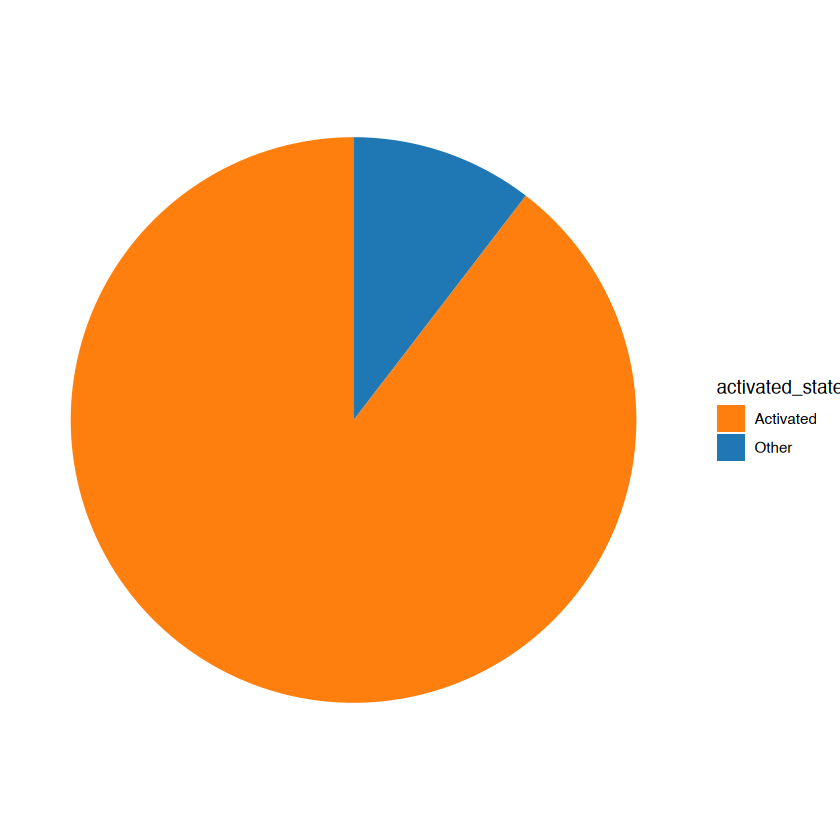

In [37]:
a=unique_time_cre_df2 %>%
    mutate(activated_state = ifelse(!hmm_state_name %in% c('No Chromatin Signal', 'Heterochromatin-H3K9me3', 'Heterochromatin-Polycomb'),
        'Activated','Other')) %>%
    dplyr::group_by(activated_state) %>%
    dplyr::summarise(n = n()) %>%
    ggplot(aes(x="", y=n, fill=activated_state))+
    geom_bar(stat='identity',width = 1, position = 'fill')+
    scale_fill_manual(values=c('Activated'='#FF7F0E','Other'='#1F77B4'))+
    coord_polar("y", start=0)+
    theme_void()
a
ggsave(glue('{output_dir}/AT1_time_cre_HMM_pie.pdf'), a,  
       width=210, height = 120, units='mm', dpi=600, bg='transparent')

`summarise()` has grouped output by 'cluster'. You can override using the `.groups` argument.


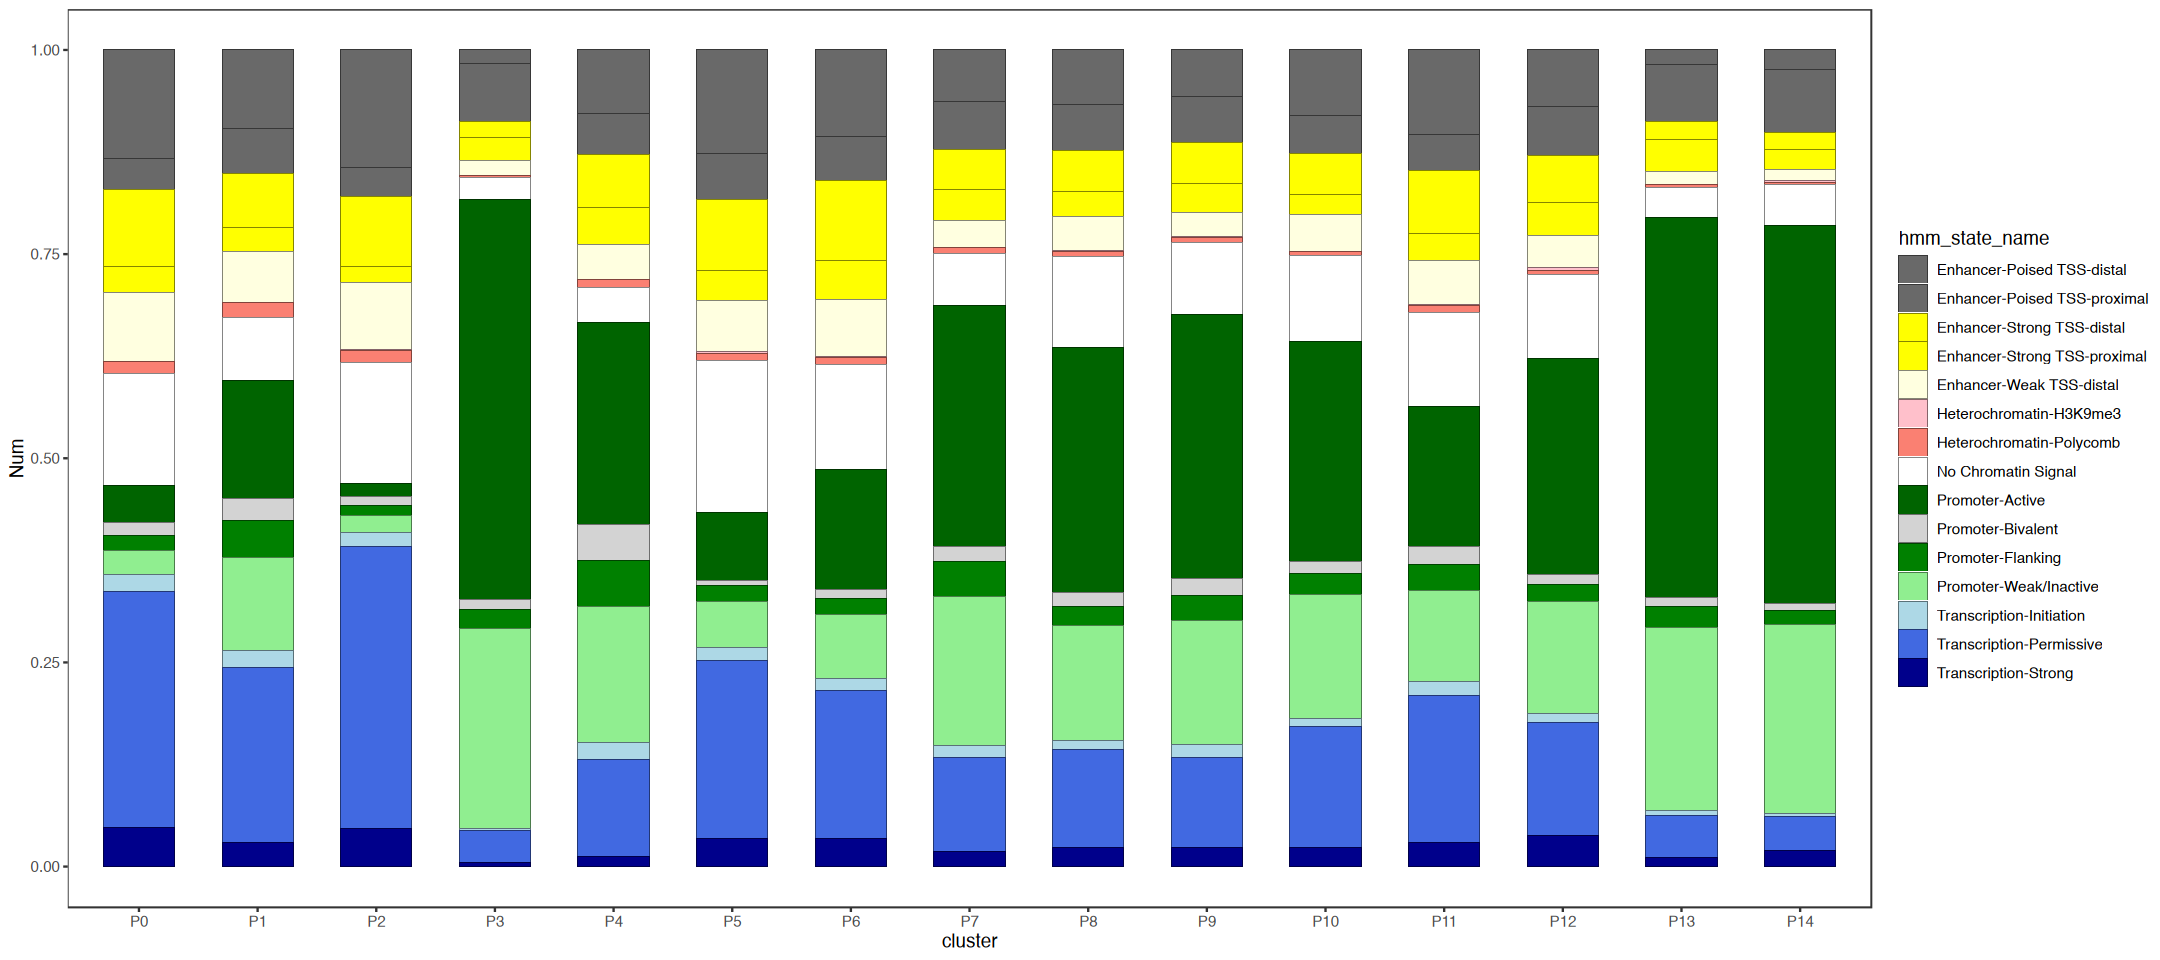

In [159]:
a=unique_time_cre_df2 %>%
    mutate(cluster=factor(cluster, time_levels)) %>%
    dplyr::group_by(cluster, hmm_state_name) %>%
    dplyr::summarise(Num=n()) %>%
    ggplot(aes(x=cluster, y=Num, fill=hmm_state_name)) +
    geom_bar(stat='identity', position = 'fill', width=0.6, color='black', size=0.1)+
    scale_fill_manual(values = chromHMM_colors_simple_color2)+
    theme_bw()+
    theme(panel.grid = element_blank())
a
ggsave(glue('{output_dir}/AT1_time_cre_HMM.pdf'), a,  
       width=210, height = 120, units='mm', dpi=600, bg='transparent')

In [16]:
top_peaks = srt_marker %>% 
  dplyr::filter(avg_log2FC >=0.1&p_val_adj <=0.05) %>%
  group_by(cluster) %>% 
  top_n(2000,avg_log2FC) %>%
  arrange(cluster, -avg_log2FC)

top_peaks$cluster = factor(top_peaks$cluster, levels = time_levels)
top_peaks = top_peaks %>% arrange(cluster)
meanM = myAveragePeak(srt, 'Time', assay=act_assay, slot='data')
meanM = log2(meanM+1)
meanM = as.matrix(meanM)
meanM = myRowScale(meanM, max = 2, min = -2,limit=TRUE)


In [19]:
srt_marker %>% 
  dplyr::filter(avg_log2FC >=0.1&p_val_adj <=0.05) %>% dim

[1] 101046      8

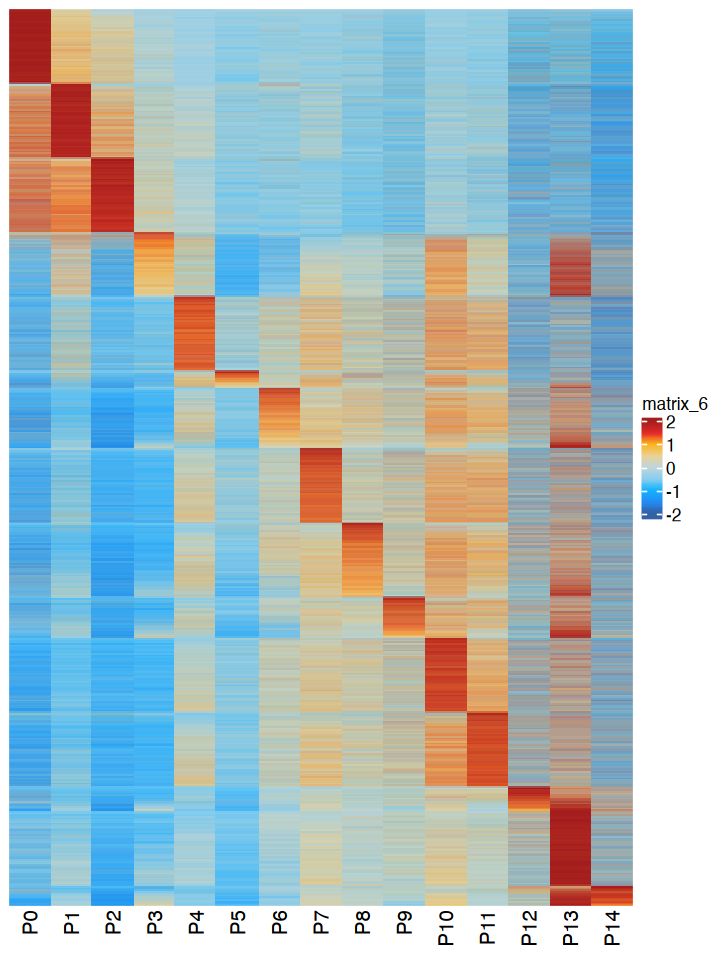

In [68]:

options(repr.plot.width=6, repr.plot.height=8)
ht = Heatmap(meanM[top_peaks$gene, time_levels],
        col = paletteContinuous(set = "solarExtra", n = 100),
        cluster_columns = F,cluster_rows = F,
        show_column_names = T, show_row_names = F,
        use_raster = T)
ht

In [69]:
pdf(glue('{output_dir}/AT1_differentialCREheatmap.pdf'), width = 6,height = 8)
draw(ht)
dev.off()

agg_record_884616499 
                   2

In [17]:
library(rGREAT)
Species = 'mm10'



rGREAT version 2.8.0
Bioconductor page: http://bioconductor.org/packages/rGREAT/
Github page: https://github.com/jokergoo/rGREAT

If you use it in published research, please cite:
Gu, Z. rGREAT: an R/Bioconductor package for functional enrichment 
  on genomic regions. Bioinformatics 2023.

This message can be suppressed by:
  suppressPackageStartupMessages(library(rGREAT))

Note: On Aug 19 2019 GREAT released version 4 where it supports `hg38`
genome and removes some ontologies such pathways. `submitGreatJob()`
still takes `hg19` as default. `hg38` can be specified by the `genome
= 'hg38'` argument. To use the older versions such as 3.0.0, specify as
`submitGreatJob(..., version = '3.0.0')`.

From rGREAT version 1.99.0, it also implements the GREAT algorithm and
it allows to integrate GREAT analysis with the Bioconductor annotation
ecosystem. By default it supports more than 500 organisms. Check the
new function `great()` and the new vignette.



Attaching package: 'rGREAT'


The fo

In [ ]:
tmp_group = list('stage1'=c('P0','P1','P2', 'P3'),
              'stage2'=c('P4','P5','P6', 'P7', 'P8', 'P9', 'P10','P11'),
              'stage3'=c('P12', 'P13', 'P14'))

Go.dataList = list()
for (i in names(tmp_group)) {
    peaks = srt_marker %>% 
                  dplyr::filter(avg_log2FC >=0.1&p_val_adj <=0.05) %>%
                  dplyr::filter(cluster%in%tmp_group[[i]])
    peaks = peaks$gene
    peaks = strsplit(peaks,split = '-')
    peak_dat = data.frame(chr = unlist(lapply(peaks, '[',1)),
                          start = unlist(lapply(peaks, '[',2)),
                          end =unlist(lapply(peaks, '[',3)))

    peak_dat = peak_dat[peak_dat$chr%in%paste0('chr',c(1:22,'X','Y')),]
    peak_gr = GRanges(seqnames = peak_dat$chr,
                      ranges = IRanges(start =as.numeric(peak_dat$start),
                                       end = as.numeric(peak_dat$end)))
    
    peak_gr = GenomicRanges::reduce(peak_gr)
    job = submitGreatJob(peak_gr,species =  Species )
    tbl = getEnrichmentTables(job)
    GO_BP = tbl$`GO Biological Process`
    GO_BP$Cluster = 'Biological Process'
    
    
    GO_MF = tbl$`GO Molecular Function`
    GO_MF$Cluster = 'Molecular Function'

    GO_CC =  tbl$`GO Cellular Component`
    GO_CC$Cluster = 'Cellular Component'

    Go.data = rbind(GO_BP,GO_CC,GO_MF)
    Go.data$Group = i 
    Go.dataList[[i]] = Go.data
}

Note: On Aug 19 2019 GREAT released version 4 which supports hg38
genome and removes some ontologies such pathways. submitGreatJob()
still takes hg19 as default. hg38 can be specified by argument `genome
= "hg38"`. To use the older versions such as 3.0.0, specify as
submitGreatJob(..., version = "3"). Set argument `help` to `FALSE` to
turn off this message.

The default enrichment table does not contain informatin of associated
genes for each input region. You can set `download_by = 'tsv'` to
download the complete table, but note only the top 500 regions can be
retreived. See the following link:

https://great-help.atlassian.net/wiki/spaces/GREAT/pages/655401/Export#Export-GlobalExport

Except the additional gene-region association column if taking 'tsv' as
the source of result, all other columns are the same if you choose
'json' (the default) as the source. Or you can try the local GREAT
analysis with the function `great()`.

Note: On Aug 19 2019 GREAT released version 4 which support

  |======================================================================| 100%


The default enrichment table does not contain informatin of associated
genes for each input region. You can set `download_by = 'tsv'` to
download the complete table, but note only the top 500 regions can be
retreived. See the following link:

https://great-help.atlassian.net/wiki/spaces/GREAT/pages/655401/Export#Export-GlobalExport

Except the additional gene-region association column if taking 'tsv' as
the source of result, all other columns are the same if you choose
'json' (the default) as the source. Or you can try the local GREAT
analysis with the function `great()`.

Note: On Aug 19 2019 GREAT released version 4 which supports hg38
genome and removes some ontologies such pathways. submitGreatJob()
still takes hg19 as default. hg38 can be specified by argument `genome
= "hg38"`. To use the older versions such as 3.0.0, specify as
submitGreatJob(..., version = "3"). Set argument `help` to `FALSE` to
turn off this message.

Don't make too frequent requests. The time break is 60s.
Pl

  |===================================================================== |  99%


The default enrichment table does not contain informatin of associated
genes for each input region. You can set `download_by = 'tsv'` to
download the complete table, but note only the top 500 regions can be
retreived. See the following link:

https://great-help.atlassian.net/wiki/spaces/GREAT/pages/655401/Export#Export-GlobalExport

Except the additional gene-region association column if taking 'tsv' as
the source of result, all other columns are the same if you choose
'json' (the default) as the source. Or you can try the local GREAT
analysis with the function `great()`.



In [565]:
saveRDS(Go.dataList, '../pycode/round_cluster02/cCRE/AT1_diff_cre_GO.rds')

In [15]:
Go.dataList = readRDS('../pycode/round_cluster02/cCRE/AT1_diff_cre_GO.rds')

In [16]:
df.dd <- do.call(rbind,lapply(Go.dataList, data.frame))

In [17]:
head(df.dd)

ID         name                                    
stage1.1 GO:0008152 metabolic process                       
stage1.2 GO:0009987 cellular process                        
stage1.3 GO:0019222 regulation of metabolic process         
stage1.4 GO:0031323 regulation of cellular metabolic process
stage1.5 GO:0043170 macromolecule metabolic process         
stage1.6 GO:0044237 cellular metabolic process              
         Binom_Genome_Fraction Binom_Expected Binom_Observed_Region_Hits
stage1.1 0.5484657             22109.20       26990                     
stage1.2 0.8087012             32599.55       36111                     
stage1.3 0.4453432             17952.23       21970                     
stage1.4 0.4240069             17092.14       21102                     
stage1.5 0.4551290             18346.70       22521                     
stage1.6 0.5035851             20300.02       24910                     
         Binom_Fold_Enrichment Binom_Region_Set_Coverage Binom_Raw_PValue
stage1.1 1.220759              0.6695443                 0               
stage1.2 1.107715              0.8958101                 0               
stage1.3 1.223804              0.5450125                 0               
stage1.4 1.234602              0.5234799                 0               
stage1.5 1.227523              0.5586813                 0               
stage1.6 1.227092              0.6179455                 0               
         Binom_Adjp_BH Hyper_Total_Genes Hyper_Expected
stage1.1 0              8684             5783.516      
stage1.2 0             14736             9814.128      
stage1.3 0              6108             4067.908      
stage1.4 0              5784             3852.125      
stage1.5 0              6610             4402.238      
stage1.6 0              7645             5091.545      
         Hyper_Observed_Gene_Hits Hyper_Fold_Enrichment Hyper_Gene_Set_Coverage
stage1.1  6677                    1.154488              0.4685943              
stage1.2 10273                    1.046756              0.7209629              
stage1.3  4621                    1.135965              0.3243035              
stage1.4  4383                    1.137814              0.3076005              
stage1.5  5153                    1.170541              0.3616394              
stage1.6  6010                    1.180388              0.4217840              
         Hyper_Term_Gene_Coverage Hyper_Raw_PValue Hyper_Adjp_BH
stage1.1 0.7688853                1.877787e-157    8.193411e-154
stage1.2 0.6971363                 2.497687e-46     3.336196e-44
stage1.3 0.7565488                 4.499486e-73     1.472457e-70
stage1.4 0.7577801                 7.616746e-70     2.373886e-67
stage1.5 0.7795764                4.052150e-128    6.630330e-125
stage1.6 0.7861347                7.307583e-177    4.782813e-173
         Cluster            Group 
stage1.1 Biological Process stage1
stage1.2 Biological Process stage1
stage1.3 Biological Process stage1
stage1.4 Biological Process stage1
stage1.5 Biological Process stage1
stage1.6 Biological Process stage1

# Time-based dimensionality reduction

In [21]:
positional_encoding <- function(time_vec, d_model = 16) {
  time_vec <- as.matrix(time_vec)
  N <- length(time_vec)
  i <- matrix(0:(d_model - 1), nrow = 1)

  angle_rates <- 1 / (10000 ^ ((2 * floor(i / 2)) / d_model))
  angle_matrix <- time_vec %*% angle_rates  # (N x d_model)

  pos_encoding <- matrix(0, nrow = N, ncol = d_model)
  even_idx <- seq(1, d_model, by = 2)
  odd_idx  <- seq(2, d_model, by = 2)

  pos_encoding[, even_idx] <- sin(angle_matrix[, even_idx])
  pos_encoding[, odd_idx]  <- cos(angle_matrix[, odd_idx])

  return(pos_encoding)
}
time_umap <- function(obj, time_vec,n.neighbors=30,dims=NULL,
                      reduction='lsi', time_weight=0.5, key='TimeLSI', assay=NULL,
                     time_coding=FALSE, time_coding_models = 30){
    if(is.null(assay)){
        assay = DefaultAssay(obj)
    }
    key_lower = tolower(key)
    X = Embeddings(obj, reduction)
    if(!is.null(dims)){
        dims = min(ncol(X), dims)
    }else{
        dims = 30
    }
    X = X[, 2:dims]
    
    if(time_coding){
        time_vec = positional_encoding(time_vec,time_coding_models)
    }
    
    New_X = cbind(X,time_vec*time_weight)
    colnames(New_X) = paste0(key,'_', 1:ncol(New_X))
    
    if(is.vector(time_vec))
    
    obj[[key_lower]] = CreateDimReducObject(New_X, key=paste0(key,'_'), assay = assay)
    obj <- RunUMAP(object = obj, 
                   reduction = key_lower,
                   dims = 1:ncol(New_X),
                   n.neighbors=n.neighbors,
                   metric = "euclidean",min.dist=1)
    return(obj)
}

In [22]:
time_numeric = as.numeric(gsub('P','', srt$Time))
srt[['Time_num']] = time_numeric

srt=time_umap(srt, srt$Time_num, dims=50, n.neighbors=30,
                reduction='lsi',time_weight=0.5)



srt <- FindNeighbors(object = srt, reduction = 'timelsi', dims = c(1:30,50))

srt <- FindClusters(object = srt, resolution = 0.2)

16:07:53 UMAP embedding parameters a = 0.115 b = 1.929

16:07:53 Read 67110 rows and found 50 numeric columns

16:07:53 Using Annoy for neighbor search, n_neighbors = 30

16:07:53 Building Annoy index with metric = euclidean, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:08:03 Writing NN index file to temp file /var/folders/j3/2xqxw8n90811p_y83sbqt8xr0000gn/T//RtmpJGrSie/file57901b8c6996

16:08:03 Searching Annoy index using 1 thread, search_k = 3000

16:08:26 Annoy recall = 100%

16:08:29 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:08:34 Initializing from normalized Laplacian + noise (using RSpectra)

16:08:36 Commencing optimization for 200 epochs, with 3753978 positive edges

16:08:36 Using rng type: pcg

16:09:19 Optimization finished

Computing nearest n

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 67110
Number of edges: 1476798

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9090
Number of communities: 45
Elapsed time: 11 seconds


38 singletons identified. 7 final clusters.



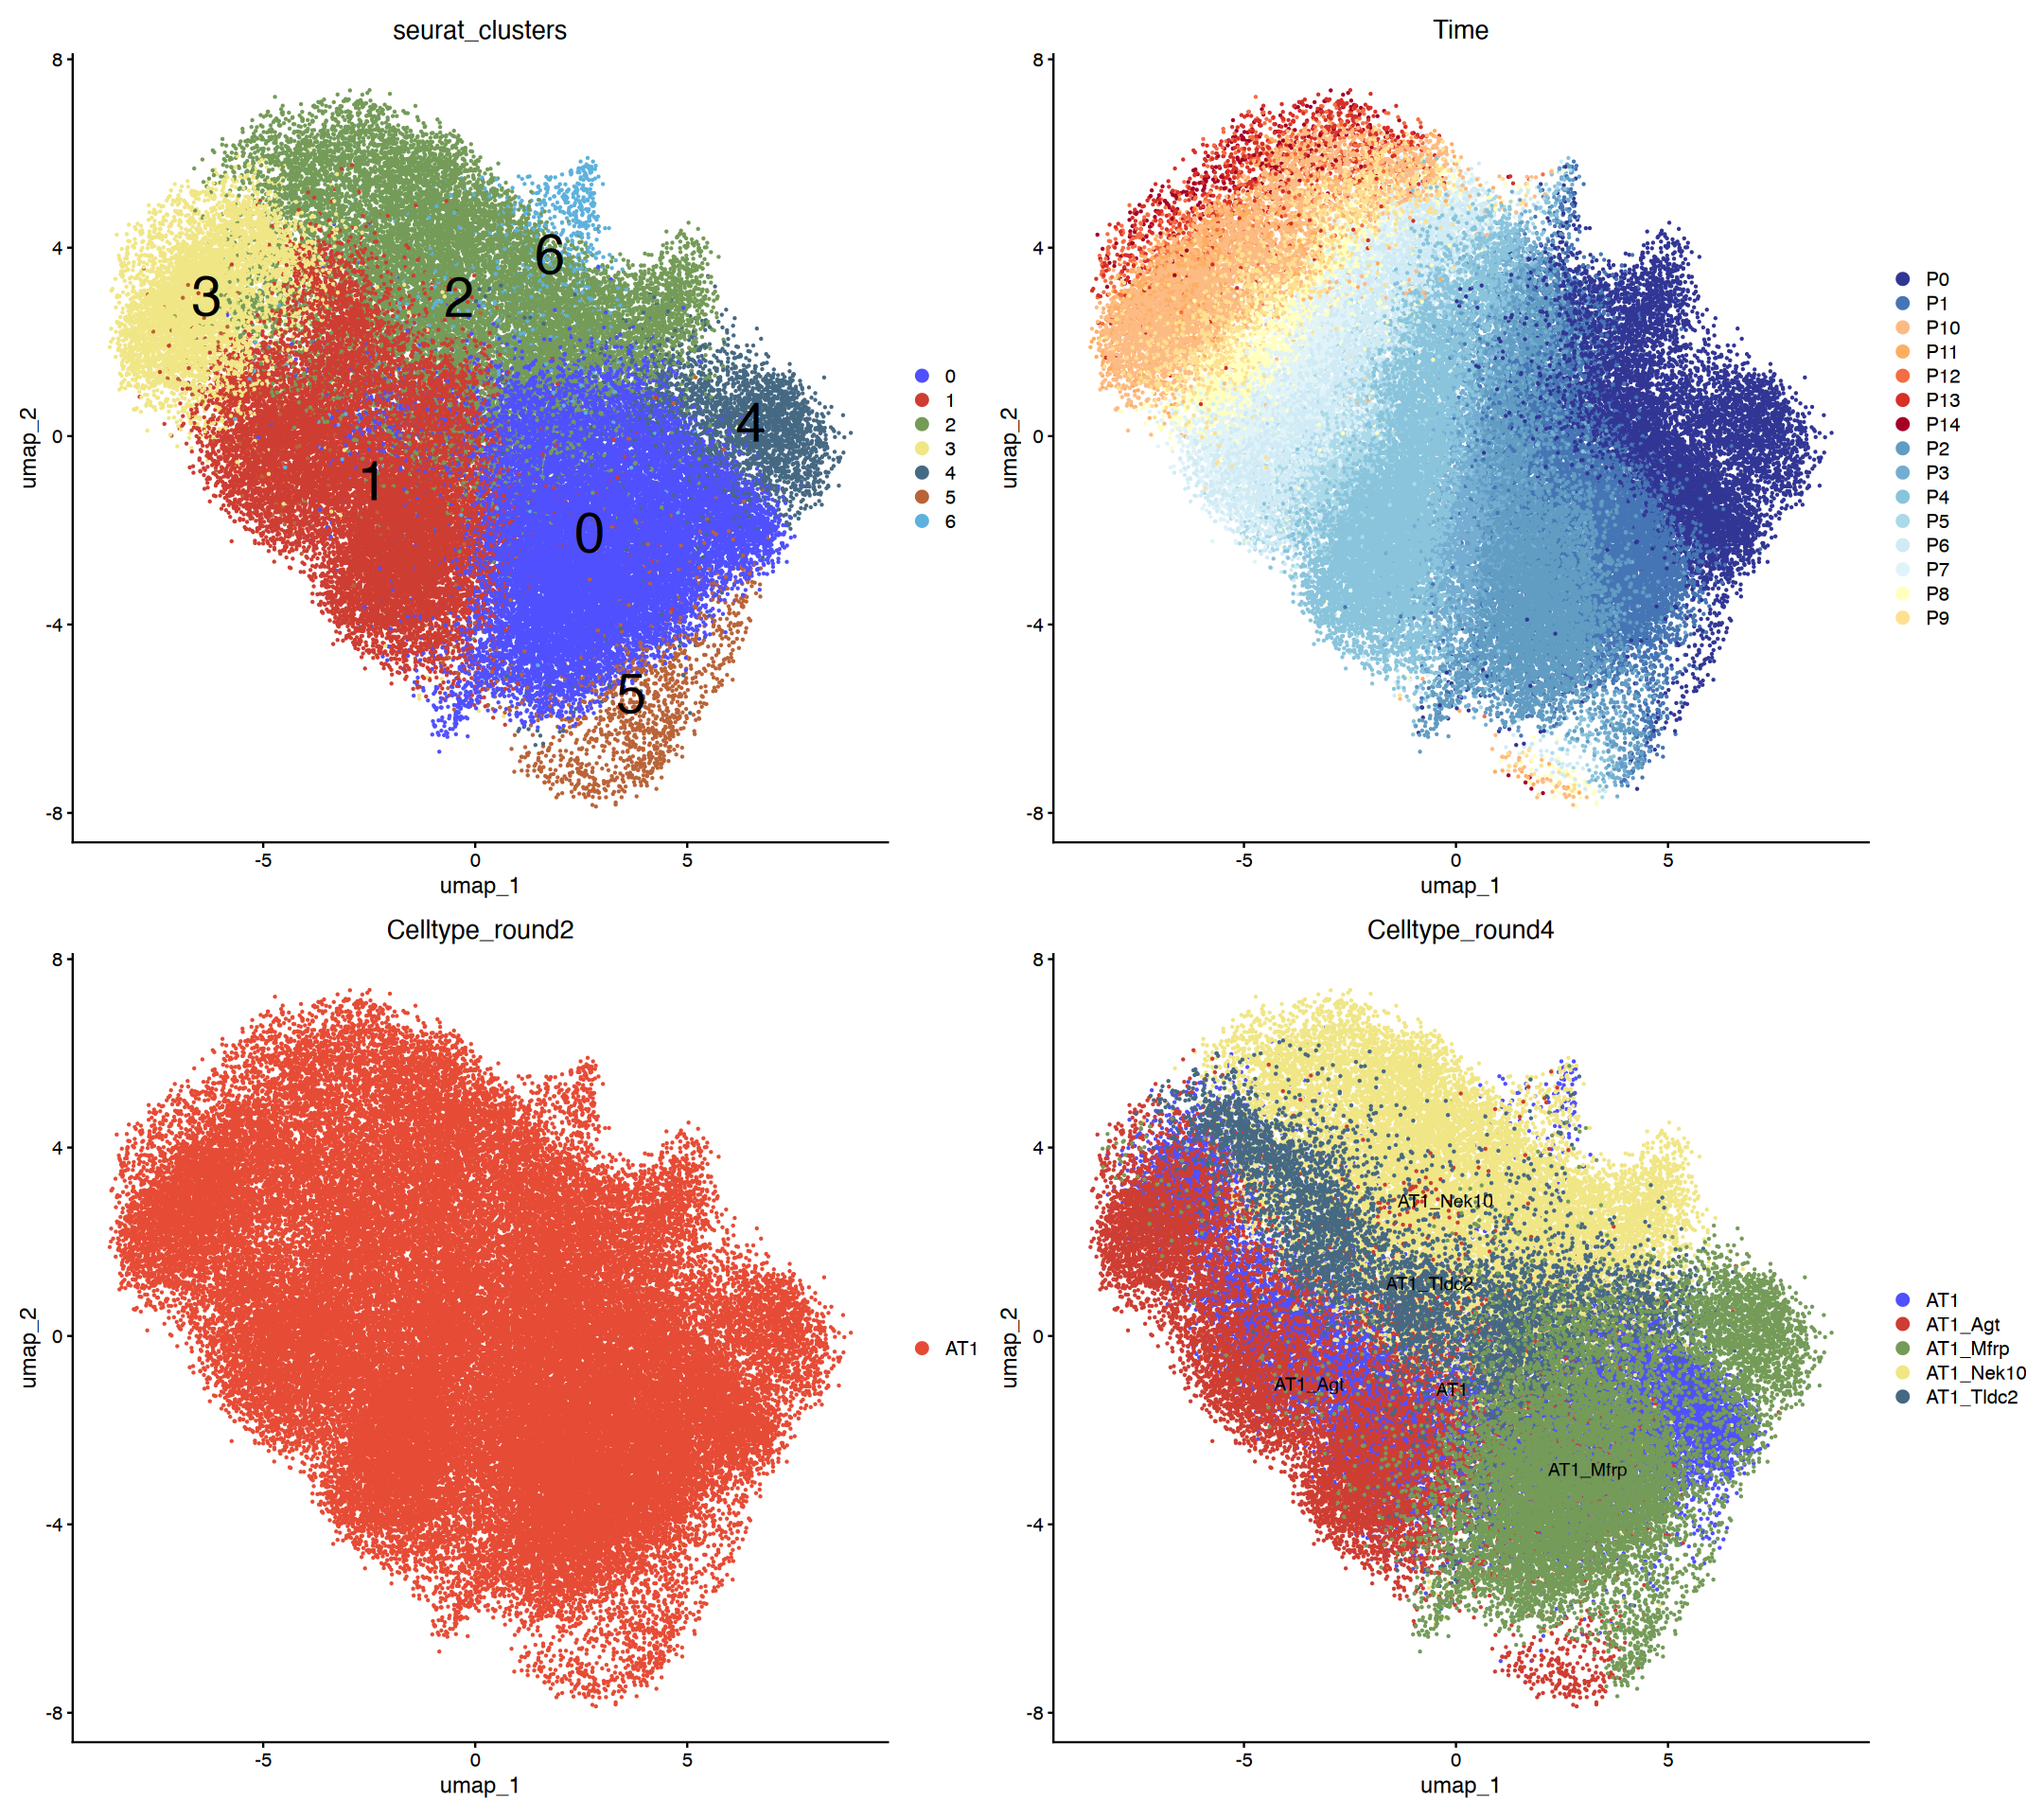

In [23]:
a = DimPlot(srt, group.by='seurat_clusters', label=TRUE,label.size=12)+scale_color_igv()
b = DimPlot(srt, group.by='Time', label=FALSE, cols=time_color2, raster = F)
c = DimPlot(srt, group.by='Celltype_round2', label=FALSE)+scale_color_npg()
d = DimPlot(srt, group.by='Celltype_round4', label=TRUE, raster = F)+scale_color_igv()
options(repr.plot.width=18, repr.plot.height=16)
a+b+c+d

In [24]:
round4_color = readRDS('./placeholder_analysis/round_cluster02/merge/round4_color.rds')

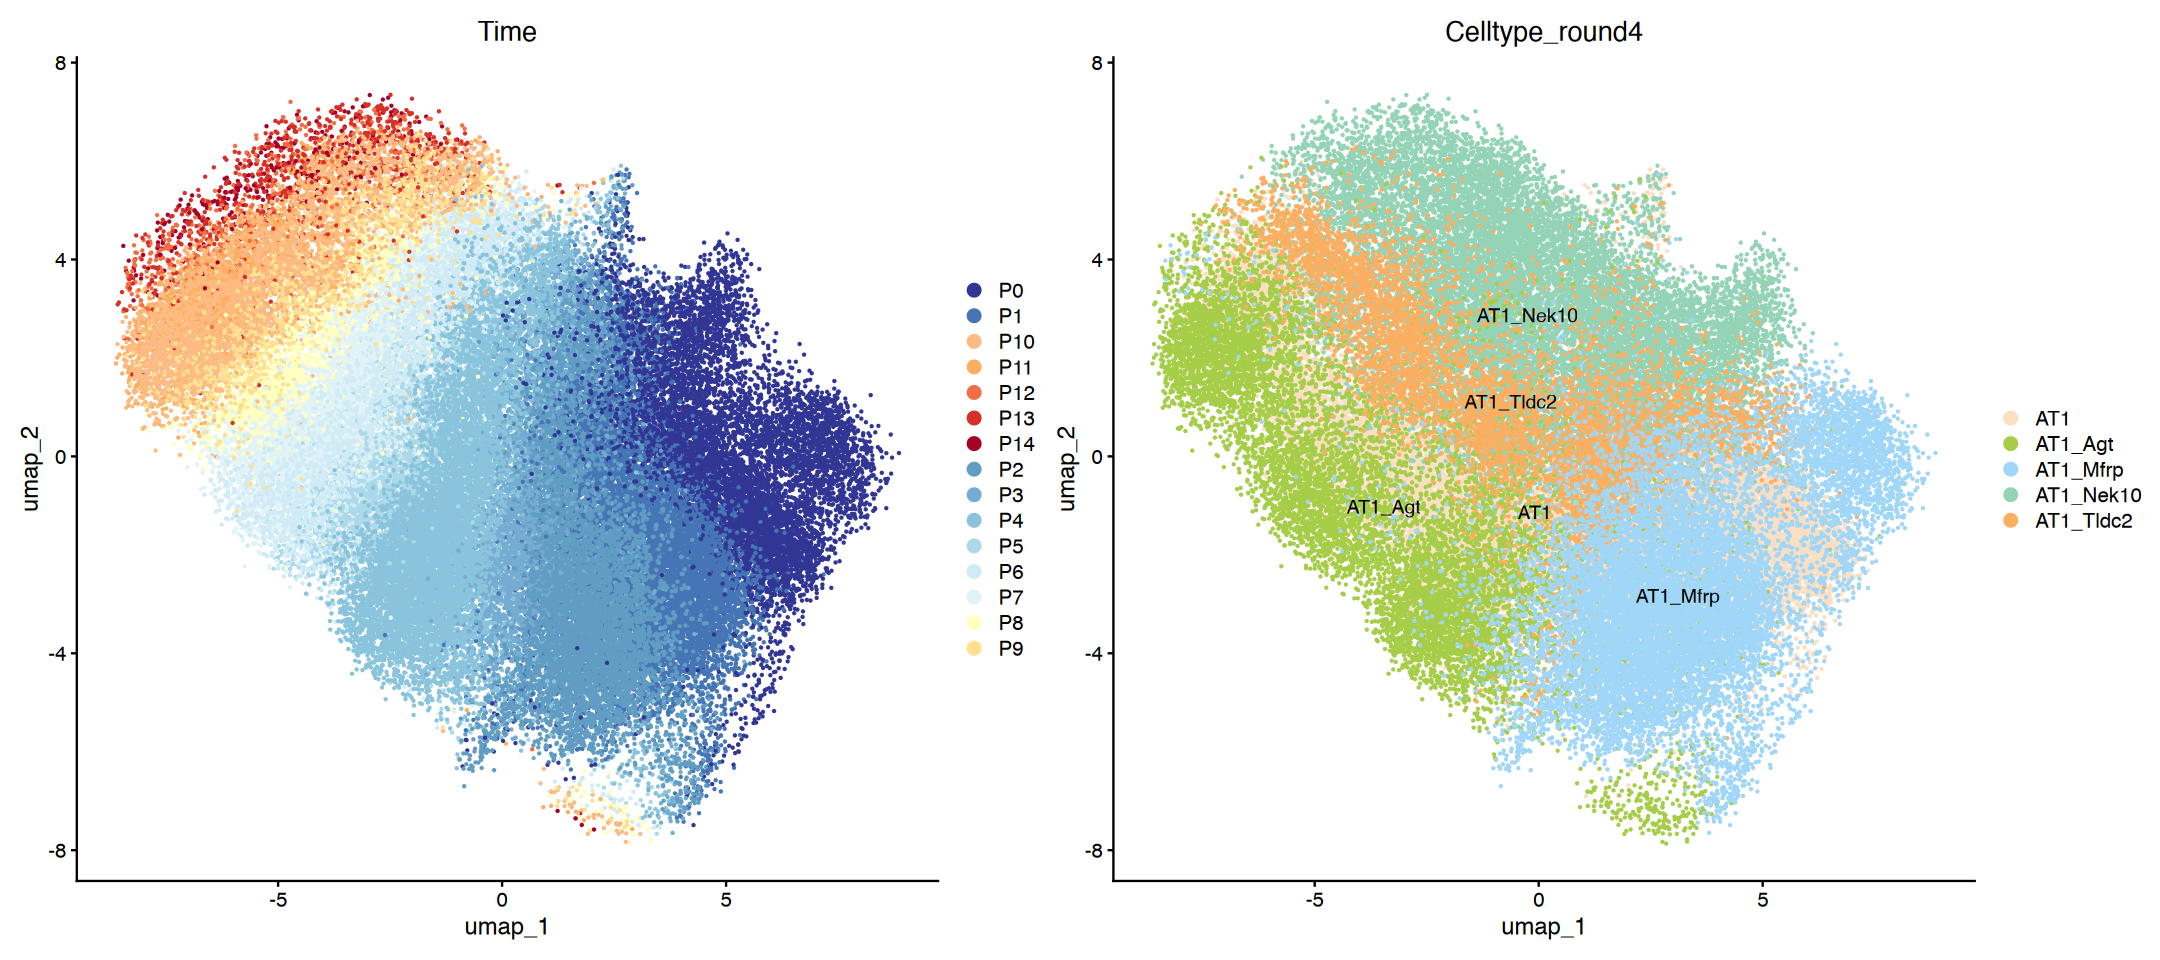

In [25]:
options(repr.plot.width=18, repr.plot.height=8)
b = DimPlot(srt, group.by='Time', label=FALSE, cols=time_color2, raster = F)
d = DimPlot(srt, group.by='Celltype_round4', label=TRUE, raster = F,cols=round4_color)
b+d

In [25]:
ggsave(glue('{output_dir}/AT1_UMAP.pdf'), b/d,  
       width=120, height = 180, units='mm', dpi=600, bg='transparent')

In [79]:
round4_color[c('AT1','AT1_Agt',  'AT1_Mfrp', 'AT1_Nek10', 'AT1_Tldc2')]

AT1   AT1_Agt  AT1_Mfrp AT1_Nek10 AT1_Tldc2 
"#FADFC3" "#A6CD48" "#A0D6F7" "#94D3B6" "#FDAE61"

In [80]:
round4_color[c('AT2','AT2_Gfra1',  'AT2_Sgta')]

AT2 AT2_Gfra1  AT2_Sgta 
"#FEE08B" "#A6D96A" "#1F78B4"

# Motif enrichment

In [28]:
library(BSgenome.Mmusculus.UCSC.mm10)
jaspar <- JASPAR2024::JASPAR2024()
pfm <- getMatrixSet(
  x = jaspar@db,opts = list(collection = "CORE",tax_group='vertebrates' , all_versions = FALSE))

hg38_mm10_TF_mapping = read.table('../hg38_mm10_TF_mapping.txt', sep='\t', header = TRUE)
hg38_mm10_TF_mapping = hg38_mm10_TF_mapping[hg38_mm10_TF_mapping$Mouse_Symbol%in%Annotation(srt)$gene_name,]

keep_TF = unique(hg38_mm10_TF_mapping$tf_name)

keep_TF_upper = toupper(keep_TF)

dup_tf = keep_TF_upper[duplicated(keep_TF_upper)]

keep_TF = setdiff(keep_TF,dup_tf)

keep_TF_motifname = c()
for(i in pfm@listData){
    if(i@name %in% keep_TF){
        keep_TF_motifname = c(keep_TF_motifname,i@ID)
    }
}
pfm_filter = pfm[names(pfm)%in%keep_TF_motifname]

jaspar = JASPAR2024::JASPAR2024()
pfm = TFBSTools::getMatrixSet(x=jaspar@db, opts=list(all_version=T, species=9606, collection='CORE'))
tf_meta = c()
for(i in pfm@listData){
  tf_meta = rbind(tf_meta, c(i@ID,i@name,i@tags$family,i@tags$symbol))
}


tf_meta = as.data.frame(tf_meta)


In [29]:
if_names = tf_meta$V2

if_names2 = sapply(if_names, function(x)strsplit(x,' ')[[1]][1])
if_names2 = gsub('_extended', '',if_names2)

tf_meta = tf_meta[tf_meta$V2%in%if_names2,]


In [30]:
motif_meta = c()
for(m in pfm_filter@listData){
    motif_meta = rbind(motif_meta, c(m@ID, paste0(m@tags$family,collapse = '::'), m@name))
}
motif_meta = as.data.frame(motif_meta)
colnames(motif_meta) = c('motif', 'family', 'TF')
rownames(motif_meta) = motif_meta$motif

In [30]:
srt <- AddMotifs(object = srt,genome = BSgenome.Mmusculus.UCSC.mm10,pfm = pfm_filter,verbose = F)

srt = AddChromVARSelf(obj = srt, Species = 'mm10')

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



In [31]:
saveRDS(srt, './placeholder_analysis/round_cluster02/cCRE//celltype_rds/Epi_AT1_sub.rds')


In [8]:
srt = readRDS('./placeholder_analysis/round_cluster02/cCRE//celltype_rds/Epi_AT1_sub.rds')

In [32]:
top_peaks = srt_marker %>% 
  dplyr::filter(avg_log2FC >=0.1&p_val_adj <=0.05) %>%
  group_by(cluster) %>% 
  top_n(2000,avg_log2FC) %>%
  arrange(cluster, -avg_log2FC)

In [33]:
meta.feature <- GetAssayData(srt, assay = act_assay, layer = "meta.features")

Cluster = unique(top_peaks$cluster)
enrich.list <- lapply(Cluster,function(i){
    message(i)
     foreground.peaks = unique(subset(top_peaks,cluster == i)$gene)
     background.peaks = AccessiblePeaks(srt,assay = act_assay)
     set.seed(1234)
     peaks.matched <- MatchRegionStats(meta.feature = meta.feature[background.peaks, ],
                                      query.feature = meta.feature[foreground.peaks, ],
                                      n = 50000)
     # background.peaks = AccessiblePeaks(object,assay = assay,idents = c(Cluster,i))
     enrich.motif <- FindMotifs(object = srt, 
                              features = foreground.peaks,
                              background = peaks.matched)
     enrich.motif$Cluster = i
     return(enrich.motif)
}) 
enrich.mat = do.call(rbind,enrich.list)

P0

Matching GC.percent distribution

Testing motif enrichment in 2000 regions

P1

Matching GC.percent distribution

Testing motif enrichment in 2000 regions

P10

Matching GC.percent distribution

Testing motif enrichment in 2000 regions

P11

Matching GC.percent distribution

Testing motif enrichment in 2000 regions

P12

Matching GC.percent distribution

Testing motif enrichment in 663 regions

P13

Matching GC.percent distribution

Testing motif enrichment in 2000 regions

P14

Matching GC.percent distribution

Testing motif enrichment in 545 regions

P2

Matching GC.percent distribution

Testing motif enrichment in 2000 regions

P3

Matching GC.percent distribution

Testing motif enrichment in 1722 regions

P4

Matching GC.percent distribution

Testing motif enrichment in 2000 regions

P5

Matching GC.percent distribution

Testing motif enrichment in 478 regions

P6

Matching GC.percent distribution

Testing motif enrichment in 1614 regions

P7

Matching GC.percent distribution



In [39]:
write.table(enrich.mat, glue('{output_dir}/AT1_Motif_Enrichment.txt'), quote = F, sep='\t', row.names = F)

In [44]:
head(enrich.mat)

motif    observed background percent.observed percent.background
1 MA0478.2 607      5314       30.35            10.628            
2 MA0489.3 699      6890       34.95            13.780            
3 MA1988.2 740      7613       37.00            15.226            
4 MA1634.2 740      7613       37.00            15.226            
5 MA0462.3 740      7613       37.00            15.226            
6 MA0835.3 740      7613       37.00            15.226            
  fold.enrichment pvalue        mlog10p  motif.name mlog10Padj p.adjust     
1 2.855664        1.178853e-135 134.9285 FOSL2      133.9743   1.060968e-134
2 2.536284        1.371302e-132 131.8629 Jun        130.9086   1.234172e-131
3 2.430054        5.743720e-132 131.2408 Atf3       130.2866   5.169348e-131
4 2.430054        5.743720e-132 131.2408 BATF       130.2866   5.169348e-131
5 2.430054        5.743720e-132 131.2408 BATF::JUN  130.2866   5.169348e-131
6 2.430054        5.743720e-132 131.2408 BATF3      130.2866   5.169348e-131
  Cluster
1 P0     
2 P0     
3 P0     
4 P0     
5 P0     
6 P0

In [43]:
enrich.mat = read.table(glue('{output_dir}/AT1_Motif_Enrichment.txt'), header = T, sep='\t')

In [40]:
glue('{output_dir}/AT1_Motif_Enrichment.txt')

./placeholder_root/mouse_lung_project/Figures/raw_figure_output/Figure3//AT1_Motif_Enrichment.txt

In [46]:
enrich.mat %>%
    filter(p.adjust<0.05) %>% pull(motif) %>% unique() %>% length()

[1] 345

## Motif enrichment sorted scatter plot for each time point

In [47]:
plot.list=list()
for(i in time_levels){
    temp = subset(enrich.mat, Cluster == i )
    temp <- temp[order(temp$mlog10Padj, decreasing = TRUE),]
    temp$rank <- seq_len(nrow(temp))
    
    p = ggplot(temp, aes(rank, mlog10Padj, color = mlog10Padj)) + 
        geom_point(size = 2) +
        ggrepel::geom_text_repel(
            data = temp[rev(seq_len(10)), ], 
            aes(x = rank, y = mlog10Padj, label = motif.name), 
            size = label_size(6),
            nudge_x = 2,
            max.overlaps = 100,
            color = "black") +
        labs(title = i,
             color = "- log10(p.adjust)")+
        theme_few() + 
        ylab("-log10(P-adj) Motif Enrichment") + 
        xlab("Rank Sorted Motif Enriched") +
        scale_color_viridis(option = "viridis")+
        theme(plot.title = element_text(hjust = 0.5, size = 12))+NoLegend()
    plot.list[[i]]=p
}

In [48]:
ggsave(glue('{output_dir}/AT1_Motif_Enrichment_point_rank.pdf'),
       cowplot::plot_grid(plotlist = plot.list, ncol=5),
       width=320, height = 220, units='mm', dpi=600, bg='transparent')

## Plot sequences of enriched motifs

In [49]:
plotlist = lapply(time_levels, function(i){
    motif_Clus = subset(enrich.mat,Cluster == i)
    motif_Clus <- motif_Clus[order(motif_Clus$mlog10Padj, decreasing = TRUE),]
    MotifPlot(object = srt,motifs = head(motif_Clus$motif,2)) + ggtitle(label = i)+
    theme_void()+
        theme(plot.title = element_text(hjust = 0.5, size = 6,colour = 'black'), 
        strip.text = element_text(hjust = 0.5, size = 6,colour = 'black'),
        plot.background = element_rect(fill=NA, color='black', size=0.1))
        
})

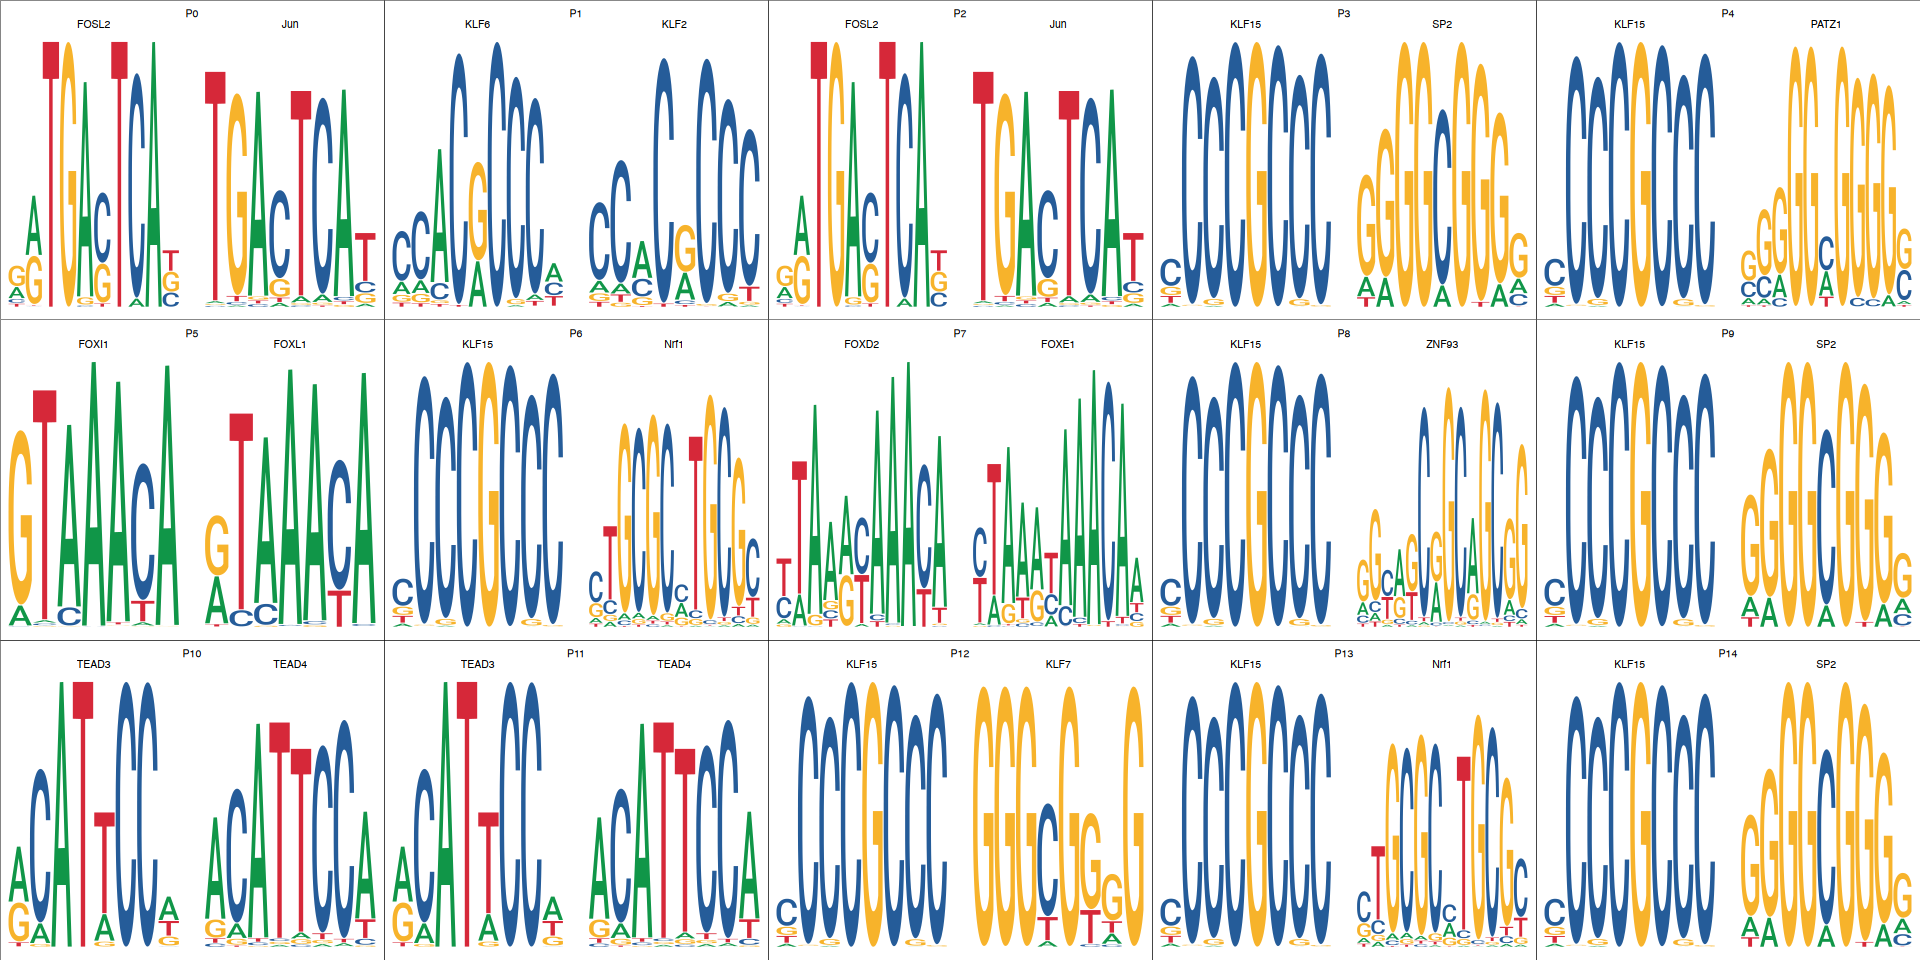

In [50]:
options(repr.plot.width=16, repr.plot.height=8)
cowplot::plot_grid(plotlist = plotlist, ncol=5)

In [51]:
ggsave(glue('{output_dir}/AT1_Motif_Enrichment_LOGO.pdf'),
       cowplot::plot_grid(plotlist = plotlist, ncol=3),
       width=58, height = 80, units='mm', dpi=600, bg='transparent')

## Enriched motif chromVAR heatmap

In [52]:
meanVar = myAveragePeak(srt, 'Time', assay='chromvar', slot='data')
meanVar = as.matrix(meanVar)
meanVar = myRowScale(meanVar, max = 2, min = -2,limit=TRUE)

In [53]:
sig_motif = enrich.mat %>%
    filter(p.adjust<0.05) %>%
    arrange(-fold.enrichment)
sig_motif$Cluster = factor(sig_motif$Cluster, levels = time_levels)
sig_motif = sig_motif %>% arrange(Cluster)

In [54]:
#sig_gene = ConvertMotifID(srt,id = sig_motif$motif,assay = act_assay)
sig_motif$sig_gene = motif_meta[sig_motif$motif, 'TF']

sig_motif = sig_motif[!duplicated(sig_motif$motif),]

sig_motif = sig_motif %>% arrange(Cluster,-mlog10p)

In [55]:
ht_data = meanVar[sig_motif$motif, ]
#rownames(ht_data) = sig_motif$sig_gene

In [56]:
ht_data = ht_data[,order(as.numeric(gsub('P','',colnames(ht_data))))]
ht_data = t(apply(ht_data, 1, function(x){
    tmp_lm = loess(formula = y~x, data=data.frame(x=1:ncol(ht_data),y=x))
    #predict(tmp_lm, x=seq(1,15,0.1))
    predict(tmp_lm, newdata=data.frame(x=seq(1,ncol(ht_data),1)))
}))

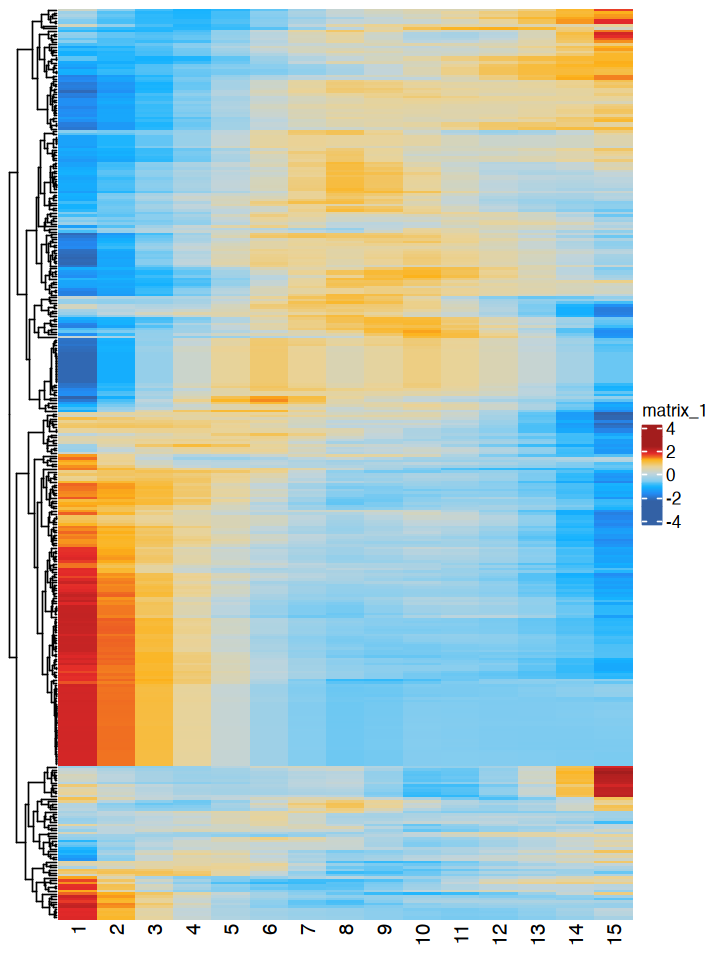

In [57]:
options(repr.plot.width=6, repr.plot.height=8)
Heatmap(ht_data,
        col = paletteContinuous(set = "solarExtra", n = 100),
        cluster_columns = F,cluster_rows = T,
        show_column_names = T, show_row_names = F,
        use_raster = F)

In [58]:
meanVar_pseudo = myAveragePeak(srt, 'Time', assay='chromvar', slot='data')
meanVar_pseudo = as.matrix(meanVar_pseudo)
meanVar_pseudo = myRowScale(meanVar_pseudo, max = 2, min = -2,limit=TRUE)

meanVar_pseudo_na = na.omit(meanVar_pseudo)

ht_data = meanVar_pseudo[sig_motif$motif, ]
ht_data = ht_data[,order(as.numeric(gsub('P','',colnames(ht_data))))]

rownames(ht_data) = sig_motif$sig_gene

ht_data = t(apply(ht_data, 1, function(x){
    tmp_lm = loess(formula = y~x, data=data.frame(x=1:ncol(ht_data),y=x))
    #predict(tmp_lm, x=seq(1,15,0.1))
    predict(tmp_lm, newdata=data.frame(x=seq(1,ncol(ht_data),1)))
}))

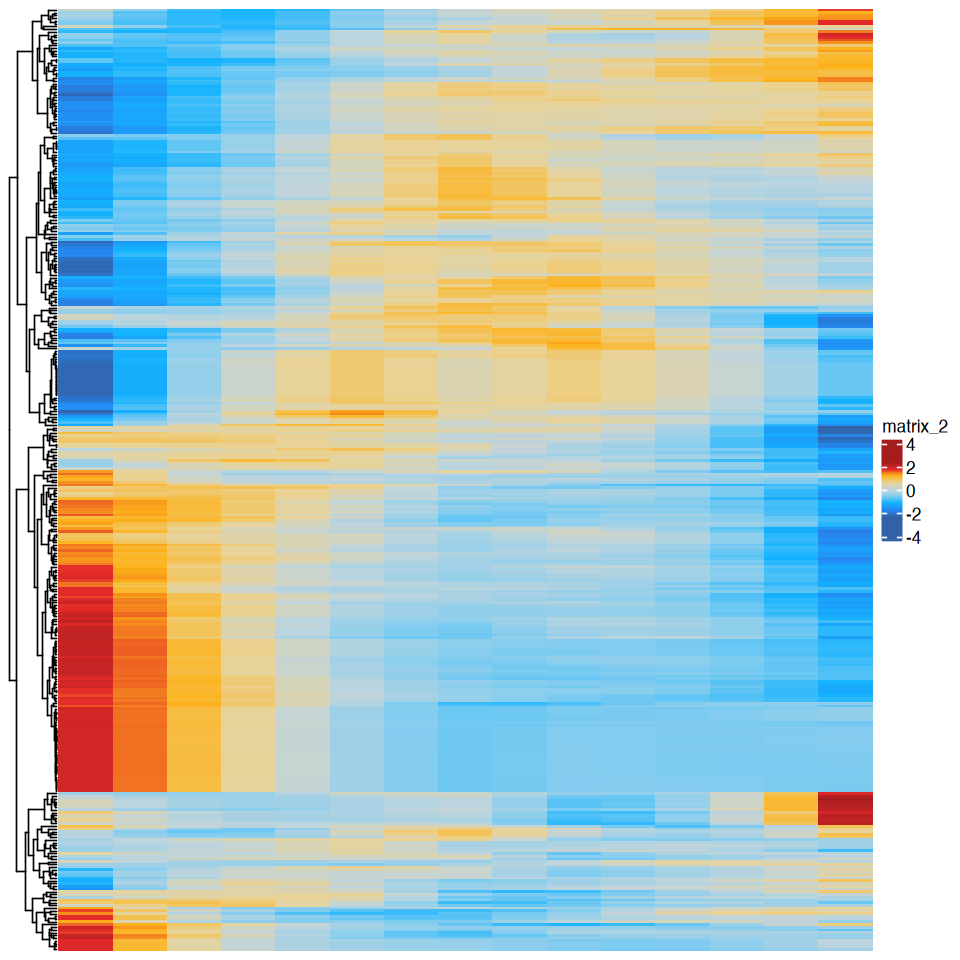

In [59]:
options(repr.plot.width=8, repr.plot.height=8)
ht=Heatmap(ht_data,
        col = paletteContinuous(set = "solarExtra", n = 100),
        cluster_columns = F,cluster_rows = T,
        show_column_names = F, show_row_names = F,
           #row_split=sig_motif$Cluster,
        use_raster = F)
ht

In [60]:
cre_acces_pseudo = myAveragePeak(srt, 'Time', assay='CRE', slot='data')
cre_acces_pseudo = log2(cre_acces_pseudo+1)
cre_acces_pseudo = as.matrix(cre_acces_pseudo)
cre_acces_pseudo = myRowScale(cre_acces_pseudo, max = 2, min = -2,limit=TRUE)

pesutotime_levels = colnames(cre_acces_pseudo)[order(as.numeric(gsub('P','',colnames(cre_acces_pseudo))))]
col_name_levels = pesutotime_levels

In [61]:
tf_ht_order = row_order(ht)
tf_ht_order = sig_motif$sig_gene[tf_ht_order]

tf_ht_order_data = ht_data[row_order(ht),]
rownames(tf_ht_order_data) = tf_ht_order
colnames(tf_ht_order_data) = col_name_levels

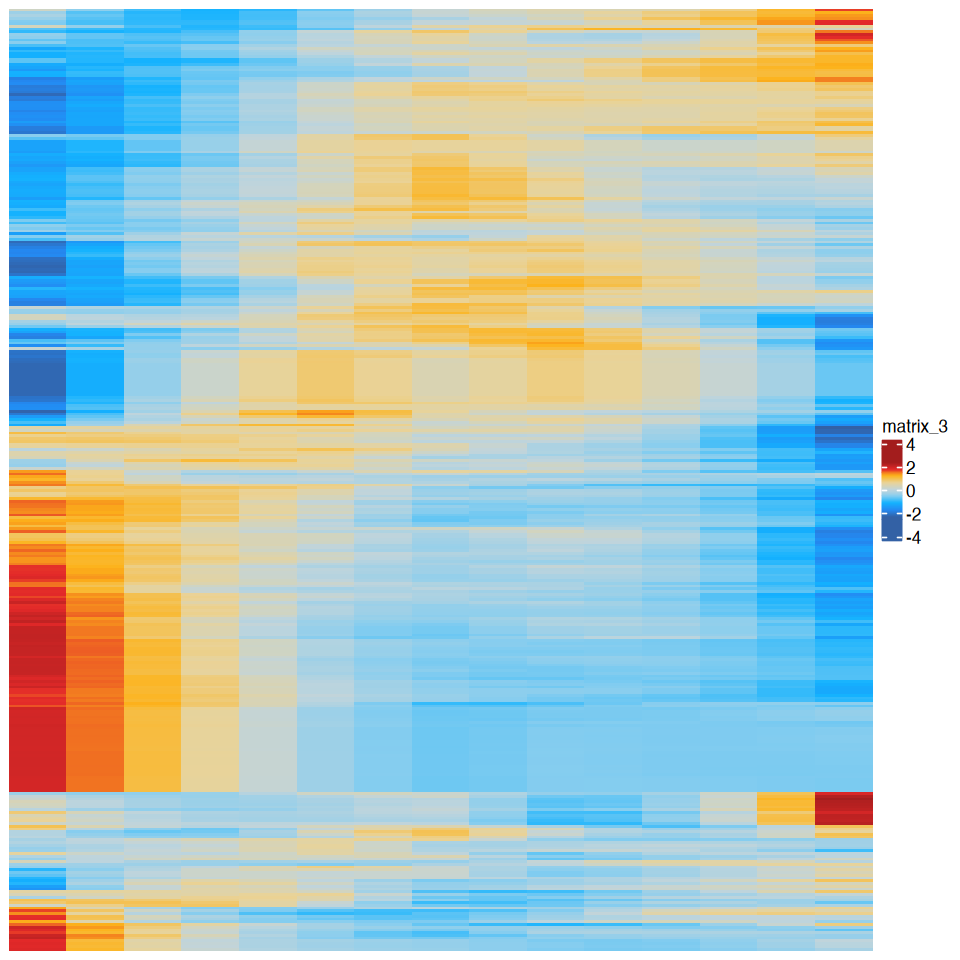

In [62]:
options(repr.plot.width=8, repr.plot.height=8)
ht_tf=Heatmap(tf_ht_order_data,
        col = paletteContinuous(set = "solarExtra", n = 100),
        cluster_columns = F,cluster_rows = F,
        show_column_names = F, show_row_names = F,
        use_raster = F)
ht_tf

In [63]:
dim(tf_ht_order_data)

[1] 345  15

In [13]:
myfragments=list()
for(x in Fragments(srt)){
    if(length(x@cells)>0){
        xname = x@path
        if(xname %in% names(myfragments)){
            myfragments[[xname]]@cells = c(myfragments[[xname]]@cells, x@cells)
        }else{
            myfragments[[xname]] = x
        }
    }
}
myfragments = unname(myfragments)

In [65]:
gb = get_genebody(object = EnsDb.Mmusculus.v79)
seqlevels(gb) = paste0('chr',seqlevels(gb))

keep_gb = gb[gb$gene_name%in%hg38_mm10_TF_mapping$Mouse_Symbol,]

#gene_body_matrix=FeatureMatrix(fragments = myfragments, features = keep_gb)

#gn = keep_gb$gene_name
#names(gn) = GRangesToString(keep_gb)

In [42]:
# rownames(gene_body_matrix) = gn

In [ ]:
saveRDS(gene_body_matrix, './placeholder_analysis//round_cluster02/merge/AT1_gene_matrix.rds')


In [66]:

gene_body_matrix = readRDS('./placeholder_analysis//round_cluster02/merge/AT1_gene_matrix.rds')

In [67]:
srt[["GeneACC"]]=NULL

srt[["GeneACC"]] = CreateAssayObject(gene_body_matrix,key = 'GeneACC')

In [68]:
meanACC_pseudo = myAveragePeak(srt, 'Time', assay="GeneACC", slot='data')
meanACC_pseudo = log2(meanACC_pseudo+1)
meanACC_pseudo = as.matrix(meanACC_pseudo)
meanACC_pseudo = myRowScale(meanACC_pseudo, max = 4, min = -4,limit=TRUE)

In [69]:
tmp_tf_acc = meanACC_pseudo[, col_name_levels]

tmp_tf_acc = t(apply(tmp_tf_acc, 1, function(x){
    tmp_lm = loess(formula = y~x, data=data.frame(x=1:ncol(tmp_tf_acc),y=x))
    #predict(tmp_lm, x=seq(1,15,0.1))
    predict(tmp_lm, newdata=data.frame(x=seq(1,ncol(tmp_tf_acc),1)))
}))

In [71]:
meanVar_pseudo2 = meanVar_pseudo[,order(as.numeric(gsub('P','',colnames(meanVar_pseudo))))]
meanVar_pseudo2 = t(apply(na.omit(meanVar_pseudo2), 1, function(x){
    tmp_lm = loess(formula = y~x, data=data.frame(x=1:ncol(meanVar_pseudo2),y=x))
    #predict(tmp_lm, x=seq(1,15,0.1))
    predict(tmp_lm, newdata=data.frame(x=seq(1,ncol(meanVar_pseudo2),1)))
}))
meanVar_pseudo2[1:3,1:3]

1         2         3         
MA0004.1 -1.369882 -1.077916 -0.7351573
MA0069.1  1.991558  1.400343  0.8442236
MA0071.1  1.737095  1.116059  0.5812117

In [73]:
all_var_df = meanVar_pseudo2[sig_motif$motif,]


all_acc_df = c()
for(select_tf in sig_motif$sig_gene){
    tmp_gene = hg38_mm10_TF_mapping[hg38_mm10_TF_mapping$tf_name==select_tf,'Mouse_Symbol']
    if(length(tmp_gene)==1){
        x = tmp_tf_acc[tmp_gene, ]
    }else{
        x = colMeans(tmp_tf_acc[tmp_gene, ,drop=F])
    }
    all_acc_df = rbind(all_acc_df, x)
}
rownames(all_acc_df) = sig_motif$sig_gene
colnames(all_acc_df) = colnames(all_var_df)

## causality

In [74]:
all_causality = t(sapply(1:nrow(all_acc_df), function(x){
    xx = cor.test(all_acc_df[x,],all_var_df[x,])
    return(c(xx$estimate,xx$p.value))
})) %>% as.data.frame()
colnames(all_causality) = c('cor', 'pvalue')
all_causality$tf = sig_motif$sig_gene

In [75]:
all_causality = c()
all_acc_df = c()
all_var_df = c()
for(select_tf in unique(sig_motif$sig_gene)){
    tmp_gene = hg38_mm10_TF_mapping[hg38_mm10_TF_mapping$tf_name==select_tf,'Mouse_Symbol']
    if(length(tmp_gene)==1){
        x = tmp_tf_acc[tmp_gene, ,drop=T]
    }else{
        x = colMeans(tmp_tf_acc[tmp_gene, ,drop=F])
    }
    tmp_motif = sig_motif[sig_motif$sig_gene==select_tf, 'motif']
    if(length(tmp_motif)==1){
        y = meanVar_pseudo2[tmp_motif,,drop=T]
    }else{
        y = colMeans(meanVar_pseudo2[tmp_motif,,drop=F])
    }
    all_acc_df = rbind(all_acc_df, x)
    all_var_df = rbind(all_var_df,y)
    xx = cor.test(x,y)
    #causal_edges$cor = xx$estimate
    #causal_edges$cor_pvalue = xx$p.value
    all_causality = rbind(all_causality, c(xx$estimate,xx$p.value,select_tf))
}
all_causality = as.data.frame(all_causality)
colnames(all_causality) = c('cor', 'pvalue', 'tf')
all_causality$cor = as.numeric(all_causality$cor)
all_causality$pvalue = as.numeric(all_causality$pvalue)

In [76]:
all_acc_df

1           2             3            4            5            6          
x  2.10374971  1.1579496193  0.439012915 -0.071458430 -0.31761819  -0.36837330
x  1.06201247  0.1721203648 -0.428788932 -0.775256601 -0.75294624  -0.50087329
x  1.61689512  1.0083529396  0.502418467  0.109328992 -0.17502409  -0.33082564
x -0.60465322 -0.1740479693  0.129107564  0.322457676  0.40024100   0.40022970
x  0.22867963 -0.0009638022 -0.149840684 -0.226399463 -0.17635262  -0.05032179
x  1.37698818  0.9813653625  0.621114135  0.318812252  0.04053994  -0.14640732
x  1.49357525  0.5778154956 -0.031475551 -0.385451374 -0.37828942  -0.14971026
x  1.18111579  0.4804404636 -0.033492522 -0.373704202 -0.48469265  -0.42926694
x  1.40533039  0.6305602135  0.057383416 -0.326562176 -0.45943265  -0.41689585
x  1.73556480  0.8131358854  0.127491800 -0.333152867 -0.51089344  -0.47073772
x  1.94847712  1.0639598777  0.388413463 -0.094140468 -0.33492918  -0.38607474
x  1.50524479  0.6180401213 -0.020187735 -0.434698535 -0.54393771  -0.44347401
x  1.58288109  0.6650349921  0.005111992 -0.423357516 -0.53528222  -0.43462329
x  1.95977941  0.9632556352  0.218367738 -0.286010841 -0.48563344  -0.45836663
x  1.81320110  0.8601307562  0.152791526 -0.321811848 -0.50223795  -0.46188701
x  1.25875208  0.5274353345 -0.008192796 -0.362363183 -0.47603715  -0.42041622
x  2.05651952  1.0641909606  0.300727502 -0.246934296 -0.51211055  -0.57365568
x  0.85056782  0.1737167118 -0.300126767 -0.583903661 -0.62028837  -0.47630301
x  0.22923472 -0.1933007756 -0.489081086 -0.659609472 -0.67716730  -0.56216372
x  1.52265249  0.5623118931 -0.133429863 -0.572165267 -0.68685770  -0.55540071
x  1.24402498  0.5465444284 -0.006535404 -0.392620933 -0.64031706  -0.67641842
x  0.41375446 -0.1030789504 -0.455398506 -0.653267935 -0.63445612  -0.47245915
x  0.05009174 -0.0226370081 -0.109129434 -0.187120653 -0.28865446  -0.34028974
x  0.59714810  0.3976243266  0.242507229  0.132411306  0.07753844   0.08632145
x  2.39690632  1.3641993774  0.570165338  0.000143584 -0.28440918  -0.36133256
x -0.38585475 -0.4140653476 -0.455076480 -0.485039770 -0.53106529  -0.52615878
x  0.38195427 -0.0232882583 -0.287162308 -0.434547980 -0.43395732  -0.33714836
x  1.29233248  0.3672161290 -0.281109397 -0.673710934 -0.71990197  -0.52813700
x  1.37847792  0.6548915500  0.226660593  0.019414991  0.17865650   0.49881453
x  0.20655749 -0.0070766224 -0.175674639 -0.288675073 -0.34389599  -0.32249761
⋮ ⋮           ⋮             ⋮            ⋮            ⋮            ⋮          
x  1.0017017   0.59175097    0.27317516   0.04048804  -0.074488284 -0.09271437
x  0.3006744   0.25875647    0.20602444   0.15960860   0.119293074  0.10853520
x  0.7729695   0.30861162   -0.01813946  -0.21711456  -0.239993973 -0.12721518
x  1.0191477   0.66244819    0.40059985   0.22008962   0.157159127  0.17401658
x  0.3093201   0.22328589    0.16596969   0.12355825   0.141511310  0.18382462
x  0.3191782  -0.12846986   -0.36195706  -0.42669442  -0.207292310  0.13641063
x  0.8257129   0.51118194    0.26520625   0.08696715  -0.010261442 -0.01736127
x  1.2048777   0.51044064   -0.03997170  -0.44448771  -0.703767089 -0.78481256
x  1.1358564   0.75345269    0.40539538   0.11419222  -0.137556695 -0.30632379
x  1.0156373   0.72951048    0.50638079   0.34207886   0.249863359  0.23470405
x  1.6667962   0.79520764    0.20218512  -0.15958756  -0.193559122 -0.01943365
x  1.5371239   0.90496376    0.43721467   0.11342884  -0.028593624 -0.02858785
x  0.6393372   0.53653585    0.43624671   0.34175522   0.253200368  0.19106389
x  1.0417950   0.52794481    0.12365460  -0.17036476  -0.347941085 -0.39721708
x  1.1522918   0.71183422    0.36662144   0.10797044  -0.025365340 -0.05978389
x  1.6689810   1.12910452    0.71313775   0.40374624   0.232321282  0.16352509
x  1.3519461   0.59521885    0.05697317  -0.29101138  -0.360922398 -0.26077102
x -0.2236103  -0.46954649   -0.57795375  -0.57245350  -0.417546637 -0.15823482
x  0.5171258   0.13274574   -0.08495169  -0.16764893

In [77]:
rownames(all_acc_df) = all_causality$tf
rownames(all_var_df) = all_causality$tf

all_causality2 = all_causality %>% filter(pvalue<0.05, abs(cor)>0.5)
acc_ht = all_acc_df[all_causality2$tf,]
var_ht = all_var_df[all_causality2$tf,]

In [78]:
options(repr.plot.width=8, repr.plot.height=16)
ht = Heatmap(cbind(acc_ht,var_ht),
          #col=circlize::colorRamp2(c(-1,-0.5,0,0.5,1),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          #col=circlize::colorRamp2(c(0,1,2,3,4),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          cluster_rows = T, cluster_columns = F,
          show_row_names = T, show_column_names = T,
          use_raster=FALSE,
          border = TRUE,
          #row_split=factor(time_levels, levels=time_levels),
          #column_split = rownames(dat_fc2),
          border_gp = gpar(col = "black",lwd = 0.2) ,
          column_names_gp = gpar(fontsize=12),
         na_col="#2c7bb6"
)

ht1 = Heatmap(acc_ht[row_order(ht),],
          #col=circlize::colorRamp2(c(-1,-0.5,0,0.5,1),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          #col=circlize::colorRamp2(c(0,1,2,3,4),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          cluster_rows = F, cluster_columns = F,
          show_row_names = T, show_column_names = F,
          use_raster=FALSE,
          border = TRUE,
          #row_split=factor(time_levels, levels=time_levels),
          #column_split = rownames(dat_fc2),
          border_gp = gpar(col = "black",lwd = 0.4) ,
              heatmap_legend = list(title='TF_acc'),
          row_names_gp = gpar(fontsize=10),
         na_col="#2c7bb6"
)

ht2 = Heatmap(var_ht[row_order(ht),],
              #col = paletteContinuous(set = "solarExtra", n = 100),
          col=circlize::colorRamp2(c(-2,-1,0,1,2),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          #col=circlize::colorRamp2(c(0,1,2,3,4),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          cluster_rows = F, cluster_columns = F,
          show_row_names = T, show_column_names = F,
          use_raster=FALSE,
          border = TRUE,
          #row_split=factor(time_levels, levels=time_levels),
          #column_split = rownames(dat_fc2),
          border_gp = gpar(col = "black",lwd = 0.4) ,
              heatmap_legend = list(title='Motif Var'),
          row_names_gp = gpar(fontsize=10),
         na_col="#2c7bb6"
)

ht3 = Heatmap(all_causality2[row_order(ht),'cor', drop=F],
              col = paletteContinuous(set = "solarExtra", n = 100),
          #col=circlize::colorRamp2(c(-2,-1,0,1,2),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          #col=circlize::colorRamp2(c(0,1,2,3,4),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          cluster_rows = F, cluster_columns = F,
          show_row_names = T, show_column_names = F,
          use_raster=FALSE,
              width=unit(5,'mm'),
          #border = TRUE,
          #row_split=factor(time_levels, levels=time_levels),
          #column_split = rownames(dat_fc2),
          #border_gp = gpar(col = "black",lwd = 0.4) ,
          row_names_gp = gpar(fontsize=10),
              heatmap_legend = list(title='Correlation'),
         na_col="#2c7bb6"
)

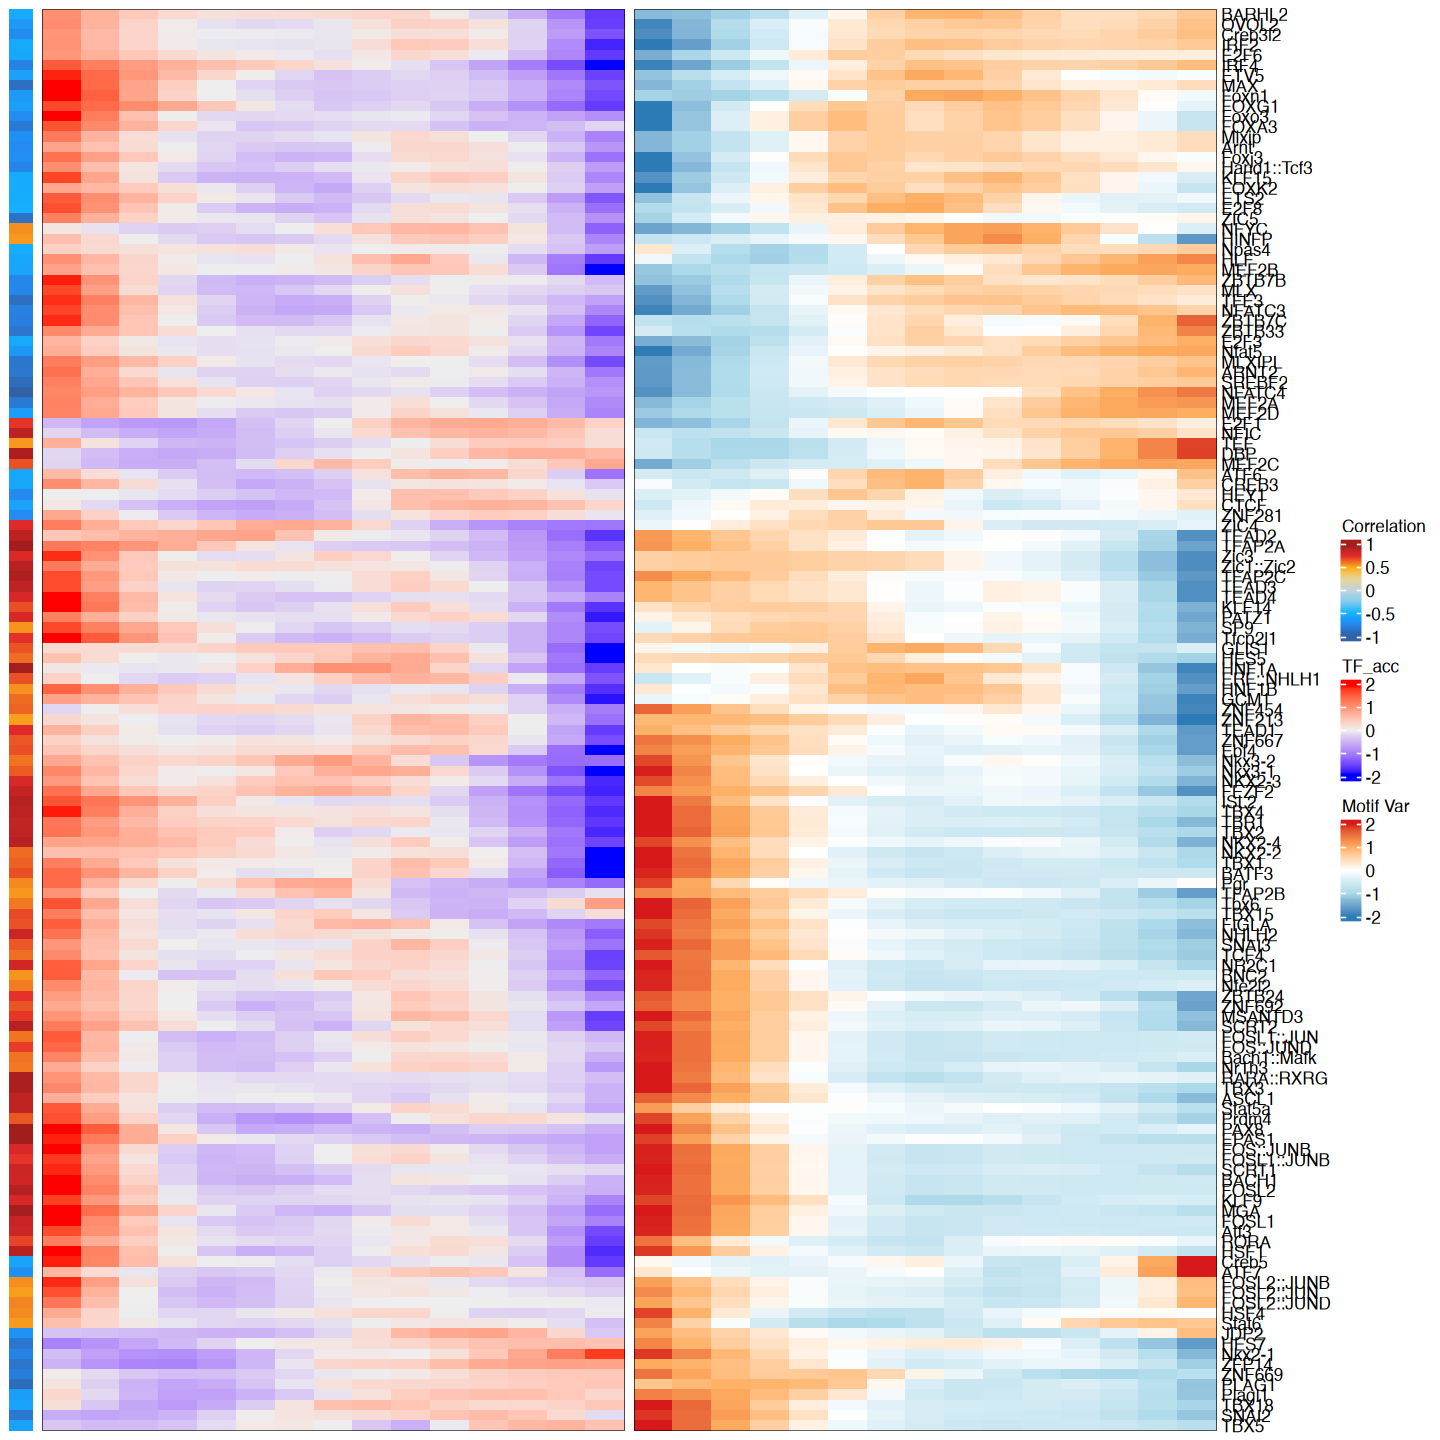

In [79]:
options(repr.plot.width=12, repr.plot.height=12)
ht3+ht1+ht2

In [80]:
options(repr.plot.width=6, repr.plot.height=8)
ht=Heatmap(var_ht,
              #col = paletteContinuous(set = "solarExtra", n = 100),
          col=circlize::colorRamp2(c(-2,-1,0,1,2),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          #col=circlize::colorRamp2(c(0,1,2,3,4),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          cluster_rows = T, cluster_columns = F,
          show_row_names = T, show_column_names = F,
          use_raster=FALSE,
          border = TRUE,
          #row_split=factor(time_levels, levels=time_levels),
          #column_split = rownames(dat_fc2),
          border_gp = gpar(col = "black",lwd = 0.4) ,
              heatmap_legend = list(title='Motif Var'),
          row_names_gp = gpar(fontsize=10),
         na_col="#2c7bb6"
)
ht_cl = cutree(as.hclust(row_dend(ht)),10)
ht_cl = sort(ht_cl)

In [131]:
saveRDS(list(var_ht=var_ht,
             ht_cl = ht_cl), './placeholder_analysis/round_cluster02/merge/AT1_TF_var_ht.rds')

In [132]:
AT1_TF_var_ht = readRDS('./placeholder_analysis/round_cluster02/merge/AT1_TF_var_ht.rds')
var_ht = AT1_TF_var_ht$var_ht
ht_cl = AT1_TF_var_ht$ht_cl

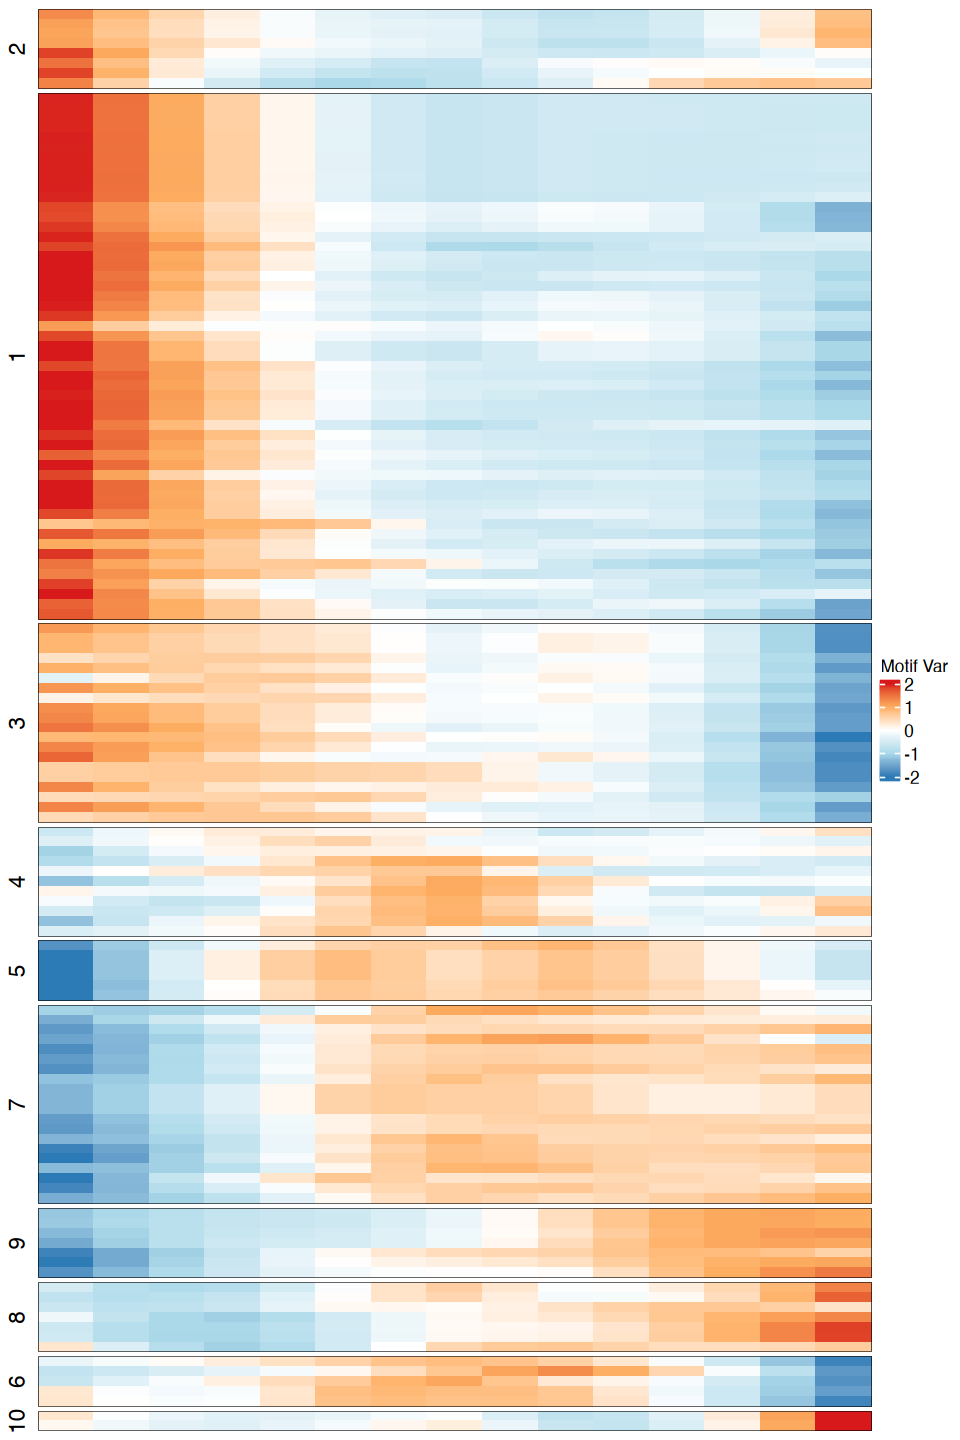

In [133]:
htx = Heatmap(var_ht[names(ht_cl),],
              #col = paletteContinuous(set = "solarExtra", n = 100),
          col=circlize::colorRamp2(c(-2,-1,0,1,2),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          #col=circlize::colorRamp2(c(0,1,2,3,4),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          cluster_rows = F, cluster_columns = F,
          show_row_names = F, show_column_names = F,
          use_raster=FALSE,
          border = TRUE,
          #row_split=factor(ht_cl, levels = c(8,2,6,3,1,4,5,7,9,10)),
          row_split=factor(ht_cl, levels = c(2,1,3,4,5,7,9,8,6,10)),
          #column_split = rownames(dat_fc2),
          border_gp = gpar(col = "black",lwd = 0.4) ,
              heatmap_legend = list(title='Motif Var'),
          row_names_gp = gpar(fontsize=10),
         na_col="#2c7bb6"
)
htx


## transcription_factor_functional_enrichment

In [ ]:
AT1_TF_var_ht = readRDS('./placeholder_analysis/round_cluster02/merge/AT1_TF_var_ht.rds')
var_ht = AT1_TF_var_ht$var_ht
ht_cl = AT1_TF_var_ht$ht_cl

In [89]:
motif_meta$family_abbr = family_abbr[motif_meta$family]

motif_meta[is.na(motif_meta$family_abbr),'family_abbr'] = motif_meta[is.na(motif_meta$family_abbr),'family']

In [92]:
write.table(motif_meta, '../share_motifmeta.txt', quote=F, sep='\t', row.names = F)

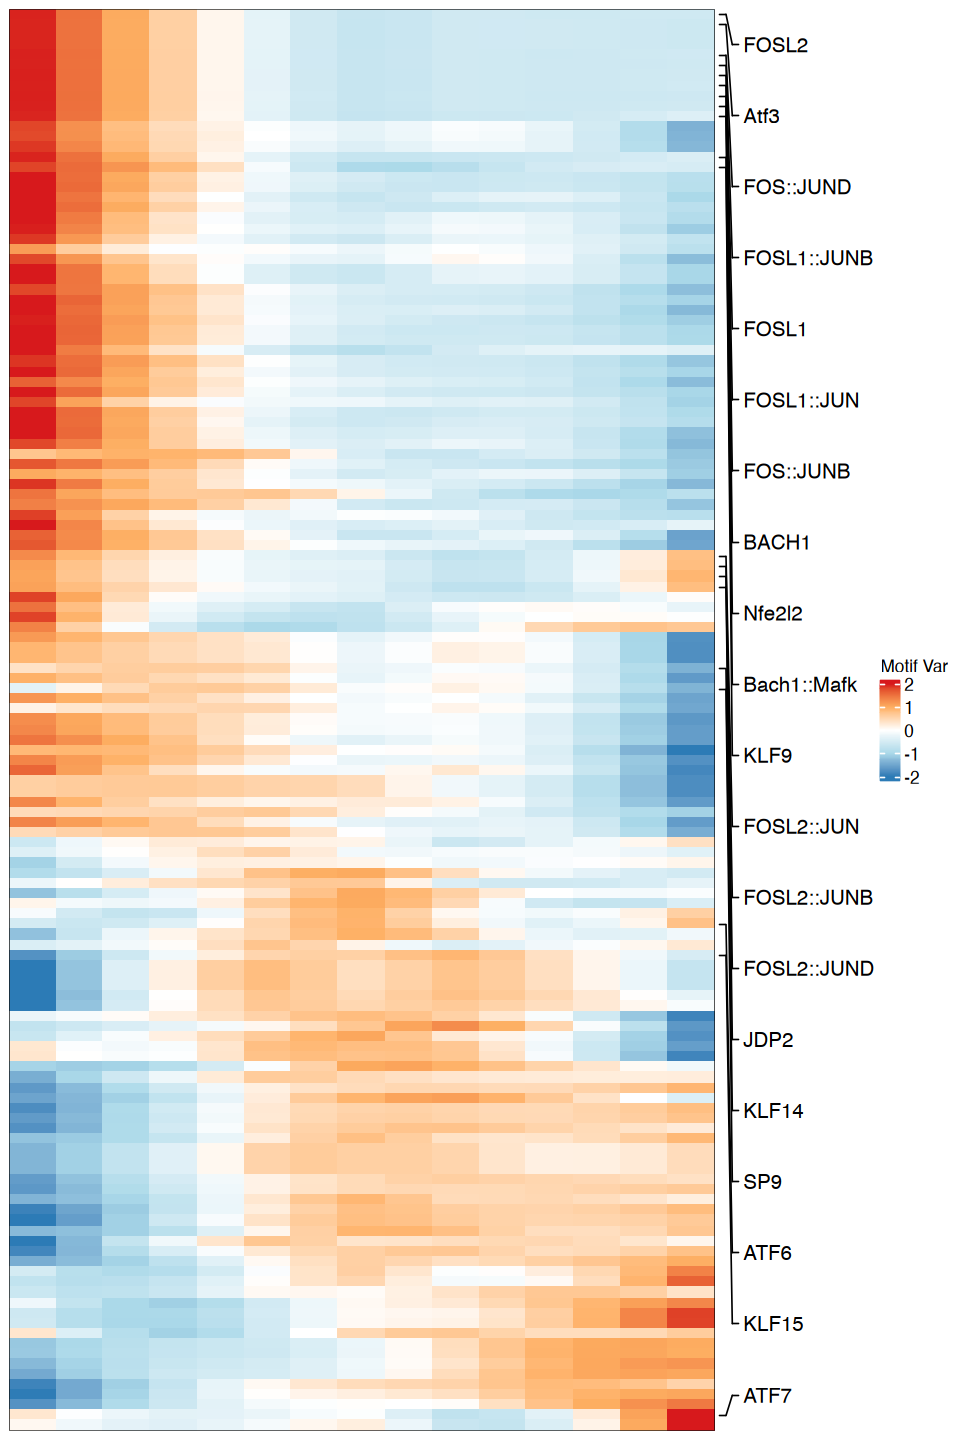

In [115]:
options(repr.plot.width=8, repr.plot.height=12)
unique_TF = unique(need_label_gene$TF)
label_pos = na.omit(match(unique_TF,names(ht_cl)))
ra = rowAnnotation(TF = anno_mark(at=label_pos, labels=unique_TF,padding=unit(12,'mm')))
#top_an = HeatmapAnnotation(Time=)
ht1 = Heatmap(var_ht[names(ht_cl),],
              #col = paletteContinuous(set = "solarExtra", n = 100),
          col=circlize::colorRamp2(c(-2,-1,0,1,2),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          #col=circlize::colorRamp2(c(0,1,2,3,4),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          cluster_rows = F, cluster_columns = F,
          show_row_names = F, show_column_names = F,
        right_annotation=ra,
          use_raster=T,
          border = TRUE,
          #row_split=factor(ht_cl, levels = c(2,1,3,4,5,7,9,8,6,10)),
          #column_split = rownames(dat_fc2),
          border_gp = gpar(col = "black",lwd = 0.4) ,
              heatmap_legend = list(title='Motif Var'),
          row_names_gp = gpar(fontsize=10),
         na_col="#2c7bb6"
)
ht1

In [116]:
pdf(glue('{output_dir}/motifchange_heatmap_mark_transcription_factors02.pdf'), width = 4,height = 4)
draw(ht1)
dev.off()

agg_record_909403024 
                   2

In [134]:
library(clusterProfiler)
library(org.Mm.eg.db)
library(DOSE)

In [122]:
var_order = unlist(row_order(htx))

# build network

In [123]:
sig_motif = enrich.mat %>%
    filter(p.adjust<0.05) %>%
    arrange(-fold.enrichment)

motif_region = StringToGRanges(unique(top_peaks$gene))

my_CollapseToLongestTranscript <- function (ranges) 
{
  range.df <- as.data.table(x = ranges)
  range.df$strand <- as.character(x = range.df$strand)
  range.df$strand <- ifelse(test = range.df$strand == "*", 
    yes = "+", no = range.df$strand)
  collapsed <- range.df[, .(unique(seqnames), min(start), 
    max(end), strand[[1]], gene_biotype[[1]], gene_name[[1]]), 
    "gene_id"]
  colnames(x = collapsed) <- c("gene_id", "seqnames", "start", 
    "end", "strand", "gene_biotype", "gene_name")
  collapsed$gene_name <- make.unique(names = collapsed$gene_name)
  gene.ranges <- makeGRangesFromDataFrame(df = collapsed, 
    keep.extra.columns = TRUE)
  return(gene.ranges)
}


gene.coords <- my_CollapseToLongestTranscript(ranges = Annotation(srt))

tss = promoters(gene.coords, upstream = 2000, downstream = 0)

#tss = resize(gene.coords, width=1, fix='start')

hits = findOverlaps(motif_region, tss)

CRE_TssGene = data.frame(
    'CRE' = GRangesToString(motif_region[queryHits(hits)]),
    'Gene' = tss[subjectHits(hits)]$gene_name
)
#rownames(CRE_TssGene) = CRE_TssGene$CRE

CRE_TssGene = CRE_TssGene[!grepl('Rik', CRE_TssGene$Gene),]
CRE_TssGene = CRE_TssGene[!grepl('Gm', CRE_TssGene$Gene),]
CRE_TssGene = CRE_TssGene[!grepl('-', CRE_TssGene$Gene),]

In [124]:
CRE_TssGene = CRE_TssGene[!duplicated(CRE_TssGene$CRE),]

rownames(CRE_TssGene) = CRE_TssGene$CRE

sig_motifs = unique(sig_motif$motif)
motif_data = as.matrix(GetMotifData(srt))[CRE_TssGene$CRE,sig_motifs]

GRN_init = melt(motif_data) %>% 
    filter(value==TRUE)
GRN_init = GRN_init[,1:2]
colnames(GRN_init) = c('CRE', 'Motif')
GRN_init$CRE = as.vector(GRN_init$CRE)
GRN_init$Motif = as.vector(GRN_init$Motif)

GRN_init$closest_gene = CRE_TssGene[GRN_init$CRE, 'Gene']
GRN_init[,c('family', 'TF')] = motif_meta[GRN_init$Motif, c('family', 'TF')]
GRN_init = na.omit(GRN_init)
GRN_init = GRN_init %>% filter(TF%in%all_causality2$tf)
head(GRN_init)
dim(GRN_init)

CRE                       Motif    closest_gene
1 chr12-56689655-56690156   MA0527.2 Pax9        
2 chr11-5898460-5898961     MA0527.2 Myl7        
3 chr10-45335458-45335959   MA0527.2 Bves        
4 chr11-113619034-113619535 MA0527.2 Sstr2       
5 chr11-65269750-65270251   MA0527.2 Myocd       
6 chr1-75208854-75209355    MA0527.2 Stk16       
  family                                               TF    
1 Other factors with up to three adjacent zinc fingers ZBTB33
2 Other factors with up to three adjacent zinc fingers ZBTB33
3 Other factors with up to three adjacent zinc fingers ZBTB33
4 Other factors with up to three adjacent zinc fingers ZBTB33
5 Other factors with up to three adjacent zinc fingers ZBTB33
6 Other factors with up to three adjacent zinc fingers ZBTB33

[1] 44803     5

In [125]:
cre_acces_pseudo = myAveragePeak(srt, 'Time', assay='CRE', slot='data')
cre_acces_pseudo = log2(cre_acces_pseudo+1)
cre_acces_pseudo = as.matrix(cre_acces_pseudo)
cre_acces_pseudo = myRowScale(cre_acces_pseudo, max = 2, min = -2,limit=TRUE)

meanVar_pseudo = myAveragePeak(srt, 'Time', assay='chromvar', slot='data')
meanVar_pseudo = as.matrix(meanVar_pseudo)
meanVar_pseudo = myRowScale(meanVar_pseudo, max = 2, min = -2,limit=TRUE)

pesutotime_levels = colnames(cre_acces_pseudo)[order(as.numeric(gsub('P','',colnames(cre_acces_pseudo))))]

In [126]:
GRN_init_cor = apply(GRN_init, 1, function(x){
    a = cre_acces_pseudo[x['CRE'], pesutotime_levels]
    b = meanVar_pseudo[x['Motif'], pesutotime_levels]
    xx=cor.test(a,b)
    return(c(xx$estimate, xx$p.value))
})
GRN_init_cor = as.data.frame(t(GRN_init_cor))
head(GRN_init_cor)

cor           V2        
1 -0.3031294332 0.27208934
2 -0.5106001695 0.05178662
3  0.1692534281 0.54649279
4  0.0007706093 0.99782529
5  0.1067722336 0.70488279
6  0.4102305387 0.12882349

In [127]:
# keepmotifagainCREcenter50bpwithin range
cre_center = resize(granges(srt), width=100, fix='center')

motif_pwm = toPWM(pfm_filter)

library(motifmatchr)
motif_position = matchMotifs(
    pwms=motif_pwm,
    subject = cre_center,
    genome = BSgenome.Mmusculus.UCSC.mm10,
    out = 'position'
)

motif_position_filter = GRangesList()
for(tmp_tf in names(motif_position)){
    i = motif_position[[tmp_tf]]
    i2 = i[i$score>quantile(i$score, 0.75)]
    motif_position_filter[[tmp_tf]] = i2
}

motif_pos_gr = unlist(motif_position_filter)

#motif_pos_gr = unlist(motif_position)

peak_motif_hits = findOverlaps(cre_center, motif_pos_gr)

cre_motif_df = data.frame(
    'CRE'=GRangesToString(granges(srt))[queryHits(peak_motif_hits)],
    'motif'=names(motif_pos_gr)[subjectHits(peak_motif_hits)]
)

cre_motif_df$combine_name = paste0(cre_motif_df$CRE, cre_motif_df$motif)



In [128]:
GRN_init_with_cor = cbind(GRN_init, GRN_init_cor)

In [129]:

GRN_init_with_cor = GRN_init_with_cor %>%
    mutate(adj = p.adjust(V2)) %>%
    filter(V2<0.01, cor>0) 

GRN_init_with_cor$combine_name = paste0(GRN_init_with_cor$CRE, GRN_init_with_cor$Motif)

GRN_init_with_cor = GRN_init_with_cor[GRN_init_with_cor$combine_name%in%cre_motif_df$combine_name,]

In [130]:
dim(GRN_init_with_cor)

[1] 170   9

In [135]:
head(GRN_init_with_cor)

CRE                      Motif    closest_gene
3   chr3-135438075-135438576 MA0527.2 Ube2d3      
4   chr11-70646984-70647485  MA0527.2 Slc25a11    
274 chr7-118534269-118534770 MA0655.1 Coq7        
279 chr3-92440786-92441287   MA0655.1 Sprr1b      
280 chr1-182564659-182565160 MA0655.1 Capn8       
282 chr9-22390348-22390849   MA0655.1 Anln        
    family                                               TF     cor      
3   Other factors with up to three adjacent zinc fingers ZBTB33 0.7735828
4   Other factors with up to three adjacent zinc fingers ZBTB33 0.8464543
274 Fos-related                                          JDP2   0.6620632
279 Fos-related                                          JDP2   0.8933555
280 Fos-related                                          JDP2   0.9039473
282 Fos-related                                          JDP2   0.9415472
    V2           adj         combine_name                    
3   7.157173e-04 1.000000000 chr3-135438075-135438576MA0527.2
4   6.916751e-05 1.000000000 chr11-70646984-70647485MA0527.2 
274 7.169689e-03 1.000000000 chr7-118534269-118534770MA0655.1
279 7.280036e-06 0.324456638 chr3-92440786-92441287MA0655.1  
280 3.786757e-06 0.168987820 chr1-182564659-182565160MA0655.1
282 1.645656e-07 0.007361347 chr9-22390348-22390849MA0655.1

In [136]:
write.table(GRN_init_with_cor, glue('{output_dir}/AT1_TF_network.txt'), quote = F, sep='\t', row.names = F)

In [137]:
GRN_init_with_cor = read.table(glue('{output_dir}/AT1_TF_network.txt'), header=T, sep='\t')

In [138]:
head(GRN_init_with_cor)

CRE                      Motif    closest_gene
1 chr3-135438075-135438576 MA0527.2 Ube2d3      
2 chr11-70646984-70647485  MA0527.2 Slc25a11    
3 chr7-118534269-118534770 MA0655.1 Coq7        
4 chr3-92440786-92441287   MA0655.1 Sprr1b      
5 chr1-182564659-182565160 MA0655.1 Capn8       
6 chr9-22390348-22390849   MA0655.1 Anln        
  family                                               TF     cor      
1 Other factors with up to three adjacent zinc fingers ZBTB33 0.7735828
2 Other factors with up to three adjacent zinc fingers ZBTB33 0.8464543
3 Fos-related                                          JDP2   0.6620632
4 Fos-related                                          JDP2   0.8933555
5 Fos-related                                          JDP2   0.9039473
6 Fos-related                                          JDP2   0.9415472
  V2           adj         combine_name                    
1 7.157173e-04 1.000000000 chr3-135438075-135438576MA0527.2
2 6.916751e-05 1.000000000 chr11-70646984-70647485MA0527.2 
3 7.169689e-03 1.000000000 chr7-118534269-118534770MA0655.1
4 7.280036e-06 0.324456638 chr3-92440786-92441287MA0655.1  
5 3.786757e-06 0.168987820 chr1-182564659-182565160MA0655.1
6 1.645656e-07 0.007361347 chr9-22390348-22390849MA0655.1

In [140]:
dim(GRN_init_with_cor)

[1] 170   9

In [143]:
library(igraph)

In [144]:
GRN_init_with_cor2 = GRN_init_with_cor[,c('TF','CRE')]
GRN_init_with_cor2 = GRN_init_with_cor2 %>% unique()
g <- graph_from_data_frame(GRN_init_with_cor2[,c('TF','CRE')] , directed = TRUE)

In [145]:
write.table(GRN_init_with_cor2, glue('{output_dir}/AT1_TF_network_cytoscape.txt'), quote = F, sep='\t', row.names = F)

In [223]:
unique_TF = unique(GRN_init_with_cor2$TF)
unique_TF

[1] "ZBTB33"      "E2F1"        "JDP2"        "FOS::JUNB"   "FOSL2::JUNB"
 [6] "FOSL2::JUND" "FOSL2"       "FOSL2::JUN"  "SP9"         "FOS::JUND"  
[11] "FOSL1"       "FOSL1::JUN"  "FOSL1::JUNB" "BACH1"       "TFAP2A"     
[16] "KLF14"       "MLX"         "ARNT2"       "PATZ1"       "Creb3l2"    
[21] "TFAP2B"      "TFAP2C"      "SREBF2"      "TFE3"        "Creb5"      
[26] "PLAG1"       "ZBTB7B"      "HLF"         "Nfe2l2"      "Bach1::Mafk"
[31] "CTCF"        "Plagl1"      "ZNF213"      "Foxj3"       "KLF9"       
[36] "MEF2B"       "NKX2-2"      "ZBTB7C"      "ASCL1"       "MEF2D"      
[41] "HNF1B"       "HNF1A"       "IRF4"        "SCRT2"       "Tbx6"       
[46] "RARA::RXRG"  "IRF2"        "NHLH2"       "MEF2A"       "ZBTB24"     
[51] "Prdm4"       "ESR2"        "MEF2C"

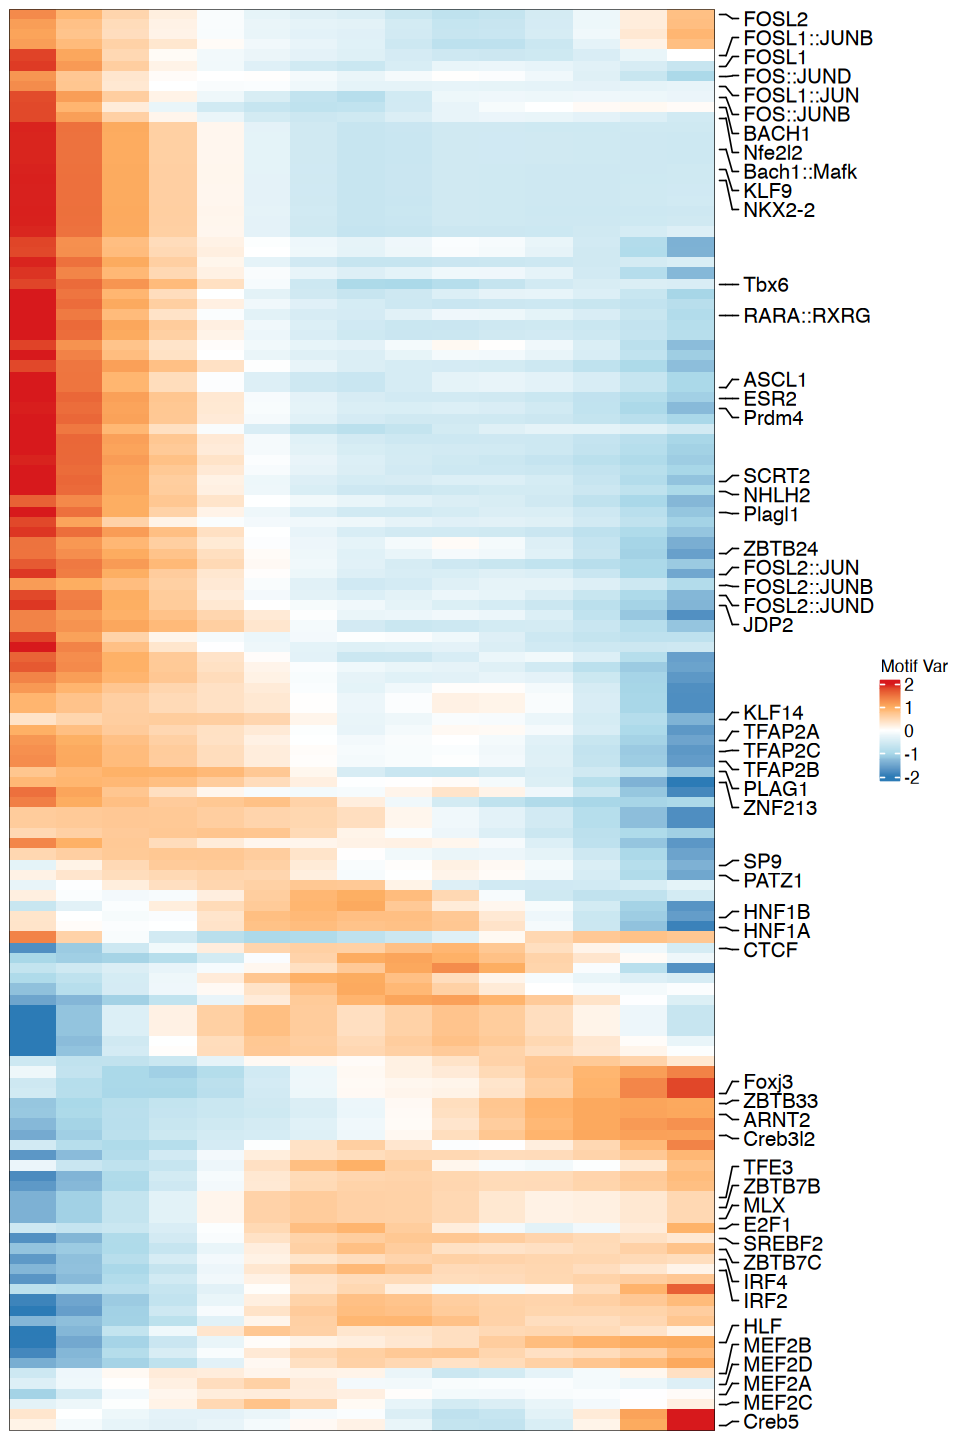

In [224]:
options(repr.plot.width=8, repr.plot.height=12)

label_pos = na.omit(match(unique_TF,names(ht_cl)))
ra = rowAnnotation(TF = anno_mark(at=label_pos, labels=unique_TF))
#top_an = HeatmapAnnotation(Time=)
ht1 = Heatmap(var_ht[names(ht_cl),][var_order,],
              #col = paletteContinuous(set = "solarExtra", n = 100),
          col=circlize::colorRamp2(c(-2,-1,0,1,2),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          #col=circlize::colorRamp2(c(0,1,2,3,4),c("#2c7bb6",'#abd9e9',"white","#fdae61","#d7191c")),
          cluster_rows = F, cluster_columns = F,
          show_row_names = F, show_column_names = F,
        right_annotation=ra,
          use_raster=T,
          border = TRUE,
          #row_split=factor(ht_cl, levels = c(2,1,3,4,5,7,9,8,6,10)),
          #column_split = rownames(dat_fc2),
          border_gp = gpar(col = "black",lwd = 0.4) ,
              heatmap_legend = list(title='Motif Var'),
          row_names_gp = gpar(fontsize=10),
         na_col="#2c7bb6"
)
ht1

In [225]:
pdf(glue('{output_dir}/motifchange_heatmap_mark_transcription_factors.pdf'), width = 8,height = 12)
draw(ht1)
dev.off()

agg_record_899786924 
                   2

In [148]:
all_nodes = names(V(g))

In [149]:
top_n = 1:4
col_name_levels2 = col_name_levels[top_n]
nodes_color_value = sapply(all_nodes, function(x){
    if(x%in%GRN_init_with_cor$CRE){
        tmp_value = rowMeans(cre_acces_pseudo[x, col_name_levels2, drop=F])
    }else{
        
        x2 = motif_meta[motif_meta$TF==x, 'motif']
        tmp_value = 0#mean(rowMeans(meanVar_pseudo[x2,col_name_levels2, drop=F]))
    }
    return(tmp_value)
})
nodes_color_value_stage1 = unname(unlist(nodes_color_value))

top_n = 5:12
col_name_levels2 = col_name_levels[top_n]
nodes_color_value = sapply(all_nodes, function(x){
    if(x%in%GRN_init_with_cor$CRE){
        tmp_value = rowMeans(cre_acces_pseudo[x, col_name_levels2, drop=F])
    }else{
        
        x2 = motif_meta[motif_meta$TF==x, 'motif']
        tmp_value = 0#mean(rowMeans(meanVar_pseudo[x2,col_name_levels2, drop=F]))
    }
    return(tmp_value)
})
nodes_color_value_stage2 = unname(unlist(nodes_color_value))

top_n = 13:15
col_name_levels2 = col_name_levels[top_n]
nodes_color_value = sapply(all_nodes, function(x){
    if(x%in%GRN_init_with_cor$CRE){
        tmp_value = rowMeans(cre_acces_pseudo[x, col_name_levels2, drop=F])
    }else{
        
        x2 = motif_meta[motif_meta$TF==x, 'motif']
        tmp_value = 0#mean(rowMeans(meanVar_pseudo[x2,col_name_levels2, drop=F]))
    }
    return(tmp_value)
})
nodes_color_value_stage3 = unname(unlist(nodes_color_value))


In [150]:
all_node_features = data.frame('node_name'=names(V(g)),
            'node_type' = sapply(names(V(g)), function(x){ifelse(x %in% GRN_init_with_cor$CRE, 'CRE', 'TF')}),
            'CRE_value_stage1' = nodes_color_value_stage1,
            'CRE_value_stage2' = nodes_color_value_stage2,
            'CRE_value_stage3' = nodes_color_value_stage3
            
            )

## network_degree_analysis

In [151]:
node_features = data.frame(
    'degree' = degree(g),
    'degree_out' = degree(g, mode='out'),
    'degree_in' = degree(g, mode='in'),
    'betweenness' = betweenness(g, directed = FALSE),
    #'closeness' = closeness(g, mode='all', normalized = TRUE),
    'eigen_central' = eigen_centrality(g, directed = FALSE)$vector,
    'pagerank' = page_rank(g, directed = TRUE)$vector
)
node_features$node_type = 'TF'
node_features[rownames(node_features)%in%GRN_init_with_cor$CRE, 'node_type'] = 'CRE'
node_features$node_name=rownames(node_features)

node_features2 = melt(node_features, id=c('node_type','node_name'))

In [152]:
head(node_features)

degree degree_out degree_in betweenness eigen_central pagerank   
ZBTB33      2      2          0           1.000000  0.0000000     0.005830904
JDP2        4      4          0           5.386713  0.5360681     0.005830904
FOS::JUNB   5      5          0          14.453380  0.5766399     0.005830904
FOSL2::JUNB 4      4          0           5.386713  0.5360681     0.005830904
FOSL2::JUND 4      4          0           5.386713  0.5360681     0.005830904
FOSL2       3      3          0         149.286713  0.2880028     0.005830904
            node_type node_name  
ZBTB33      TF        ZBTB33     
JDP2        TF        JDP2       
FOS::JUNB   TF        FOS::JUNB  
FOSL2::JUNB TF        FOSL2::JUNB
FOSL2::JUND TF        FOSL2::JUND
FOSL2       TF        FOSL2

In [153]:
all_node_features[rownames(node_features), c('degree', 'degree_out', 'degree_in')] = node_features[,1:3]

In [154]:
hmm_ann = read.csv('./placeholder_analysis/round_cluster02/cCRE//all_merge_peaks_HMMann.csv')

hmm_ann$cre = gsub(':','-',hmm_ann$cre)

hmm_ann_filter = hmm_ann %>% filter(cre%in%node_features2$node_name)

hmm_ann_filter = hmm_ann_filter %>% filter(Tissue=='lung')

hmm_ann_filter_mat = reshape2::acast(hmm_ann_filter, cre~hmm_state)

hmm_states_cre = colnames(hmm_ann_filter_mat)[apply(hmm_ann_filter_mat, 1, which.max)]
names(hmm_states_cre) = rownames(hmm_ann_filter_mat)

Using isin_encode as value column: use value.var to override.

Aggregation function missing: defaulting to length



In [155]:
all_node_features$hmm_state = hmm_states_cre[all_node_features$node_name]

In [156]:
motif_meta2 = motif_meta[, c('TF', 'family_abbr')] %>% unique()
rownames(motif_meta2) = motif_meta2$TF
head(motif_meta2 )

TF        family_abbr
Arnt      Arnt      PAS        
PAX6      PAX6      HD         
RORA      RORA      NR         
RXRA::VDR RXRA::VDR NR         
REL       REL       NFKB       
RELA      RELA      NFKB

In [157]:
all_node_features[, 'family'] = motif_meta2[all_node_features$node_name, 'family_abbr']
all_node_features

node_name                 node_type CRE_value_stage1
ZBTB33                    ZBTB33                    TF        0               
JDP2                      JDP2                      TF        0               
FOS::JUNB                 FOS::JUNB                 TF        0               
FOSL2::JUNB               FOSL2::JUNB               TF        0               
FOSL2::JUND               FOSL2::JUND               TF        0               
FOSL2                     FOSL2                     TF        0               
FOSL2::JUN                FOSL2::JUN                TF        0               
SP9                       SP9                       TF        0               
FOS::JUND                 FOS::JUND                 TF        0               
FOSL1::JUNB               FOSL1::JUNB               TF        0               
FOSL1::JUN                FOSL1::JUN                TF        0               
FOSL1                     FOSL1                     TF        0               
BACH1                     BACH1                     TF        0               
KLF14                     KLF14                     TF        0               
TFAP2A                    TFAP2A                    TF        0               
MLX                       MLX                       TF        0               
PATZ1                     PATZ1                     TF        0               
ARNT2                     ARNT2                     TF        0               
TFAP2B                    TFAP2B                    TF        0               
Creb5                     Creb5                     TF        0               
Creb3l2                   Creb3l2                   TF        0               
TFAP2C                    TFAP2C                    TF        0               
SREBF2                    SREBF2                    TF        0               
TFE3                      TFE3                      TF        0               
HLF                       HLF                       TF        0               
ZBTB7B                    ZBTB7B                    TF        0               
PLAG1                     PLAG1                     TF        0               
Nfe2l2                    Nfe2l2                    TF        0               
Bach1::Mafk               Bach1::Mafk               TF        0               
CTCF                      CTCF                      TF        0               
⋮                         ⋮                         ⋮         ⋮               
chr17-88529833-88530334   chr17-88529833-88530334   CRE       -0.57113349     
chr5-142701090-142701591  chr5-142701090-142701591  CRE        1.39389118     
chr1-134235286-134235787  chr1-134235286-134235787  CRE        0.62587664     
chr9-44104783-44105284    chr9-44104783-44105284    CRE        1.32892214     
chr8-70873542-70874043    chr8-70873542-70874043    CRE       -0.10101978     
chr2-27508102-27508603    chr2-27508102-27508603    CRE        1.06041465     
chr15-7129267-7129768     chr15-7129267-7129768     CRE        0.85845700     
chr1-128242129-128242630  chr1-128242129-128242630  CRE       -0.99790255     
chr6-87886234-87886735    chr6-87886234-87886735    CRE       -1.09558118     
chr2-73530612-73531113    chr2-73530612-73531113    CRE       -1.02532845     
chr8-84801802-84802303    chr8-84801802-84802303    CRE        1.11314329     
chr11-5898460-5898961     chr11-5898460-5898961     CRE        1.06490972     
chr14-48443710-48444211   chr14-48443710-48444211   CRE        1.31434723     
chr5-142701767-142702268  chr5-142701767-142702268  CRE        1.39946902     
chr18-60661245-60661746   chr18-60661245-60661746   CRE        1.27384630     
chr4-133601683-133602184  chr4-133601683-133602184  CRE        1.26107509     
chr7-16399796-16400297    chr7-16399796-16400297    CRE       -0.88784790     
chr17-25735662-25736163   chr17-25735662-25736163   CRE        1.18068964     
chr9-77045562-77046063    chr9-77045562-77046063    CRE       -0.54260272   

In [158]:
write.table(all_node_features, glue('{output_dir}/AT1_TF_network_cytoscape_meta.txt'), quote = F, sep='\t', row.names = F)

In [159]:
node_features2$hmm_state = hmm_states_cre[node_features2$node_name]
node_features2$hmm_state[is.na(node_features2$hmm_state)] = 'other'

In [160]:
head(node_features2)

node_type node_name   variable value hmm_state
1 TF        ZBTB33      degree   2     other    
2 TF        JDP2        degree   4     other    
3 TF        FOS::JUNB   degree   5     other    
4 TF        FOSL2::JUNB degree   4     other    
5 TF        FOSL2::JUND degree   4     other    
6 TF        FOSL2       degree   3     other

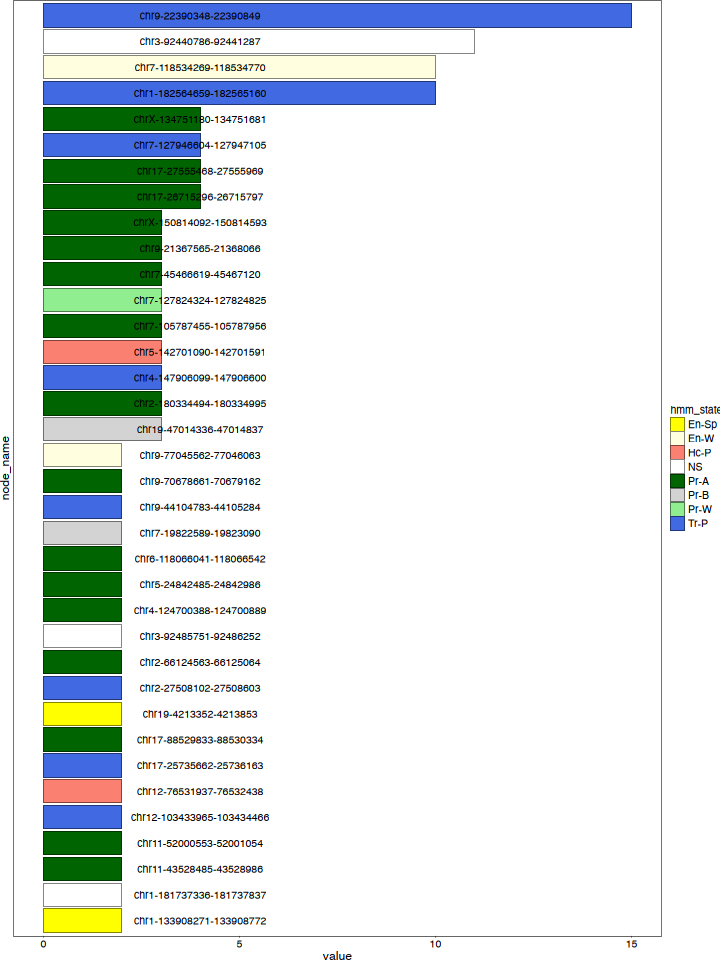

In [162]:
chromHMM_colors_simple <- c(
  "Pr-A" = "#006400",
  "Pr-W" = "#90EE90",
  "Pr-B" = "#D3D3D3",
  "Pr-F" = "#008000",
  "En-Sd" = "#FFFF00",
  "En-Sp" = "#FFFF00",
  "En-W" = "#FFFFE0",
  "En-Pd" = "#696969",
  "En-Pp" = "#696969",
  "Tr-S" = "#00008B",
  "Tr-P" = "#4169E1",
  "Tr-I" = "#ADD8E6",
  "Hc-P" = "#FA8072",
  "Hc-H" = "#FFC0CB",
  "NS"   = "#FFFFFF"
)
library(forcats)
options(repr.plot.width=6, repr.plot.height=8)
a = node_features2 %>% 
    filter(variable=='degree_in') %>%
    #filter(hmm_state!='NS') %>%
    filter(node_type!='TF') %>%
    filter(value>=2) %>%
    mutate(label_name=ifelse(value>=5, node_name, '')) %>%
    mutate(node_name=fct_reorder(node_name,value)) %>%
    ggplot(aes(y=node_name, x=value, fill=hmm_state))+
    geom_bar(stat='identity', color='black', size=0.1)+
    #geom_segment(aes(x=0, xend=value, yend=node_name), size=0.1)+
    #geom_point(size=2, shape=21)+
    geom_text(aes(x=4,label=node_name), color='black',force=4, force_pull = 0.1, size=label_size(6),
                   #nudge_x=2, nudge_y=-1
             )+
    scale_fill_manual(values = chromHMM_colors_simple)+
    theme_bw()+
    mytheme+
    theme(axis.text.y = element_blank(),
          axis.ticks.y=element_blank())
a

In [163]:
write.table(node_features2, '../pycode/round_cluster02/cCRE/AT1_net_degree.txt')

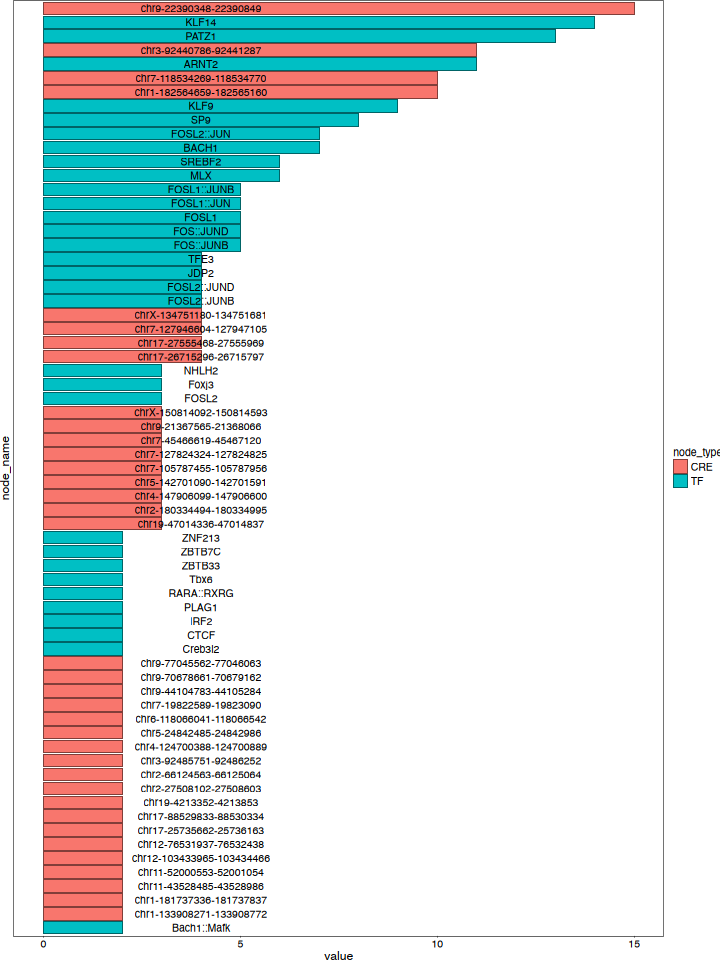

In [164]:
node_features2 %>% 
    filter(variable=='degree') %>%
    #filter(hmm_state!='NS') %>%
    #filter(node_type!='TF') %>%
    filter(value>=2) %>%
    mutate(label_name=ifelse(value>=5, node_name, '')) %>%
    mutate(node_name=fct_reorder(node_name,value)) %>%
    ggplot(aes(y=node_name, x=value, fill=node_type))+
    geom_bar(stat='identity', color='black', size=0.1)+
    #geom_segment(aes(x=0, xend=value, yend=node_name), size=0.1)+
    #geom_point(size=2, shape=21)+
    geom_text(aes(x=4,label=node_name), color='black',force=4, force_pull = 0.1, size=label_size(6),
                   #nudge_x=2, nudge_y=-1
             )+
    #scale_fill_manual(values = chromHMM_colors_simple)+
    theme_bw()+
    mytheme+
    theme(axis.text.y = element_blank(),
          axis.ticks.y=element_blank())

In [165]:
cre_order = rev(levels(a$data$node_name))

In [166]:
ggsave(glue('{output_dir}/AT1_networkCREin-degree(>1).pdf'), a,
       width=70, height=90, units='mm', dpi=600, bg='transparent')

## CREandTFrelationship

In [187]:
cre_acces_pseudo_raw = myAveragePeak(srt, 'Time', assay='CRE', slot='data')
cre_acces_pseudo_raw = log2(cre_acces_pseudo_raw+1)
cre_acces_pseudo_raw = as.matrix(cre_acces_pseudo_raw)
cre_acces_pseudo_raw = myRowScale(cre_acces_pseudo_raw, max = 2, min = -2,limit=TRUE)

meanVar_pseudo_raw = myAveragePeak(srt, 'Time', assay='chromvar', slot='data')
meanVar_pseudo_raw = as.matrix(meanVar_pseudo_raw)
meanVar_pseudo_raw = myRowScale(meanVar_pseudo_raw, max = 2, min = -2,limit=TRUE)


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


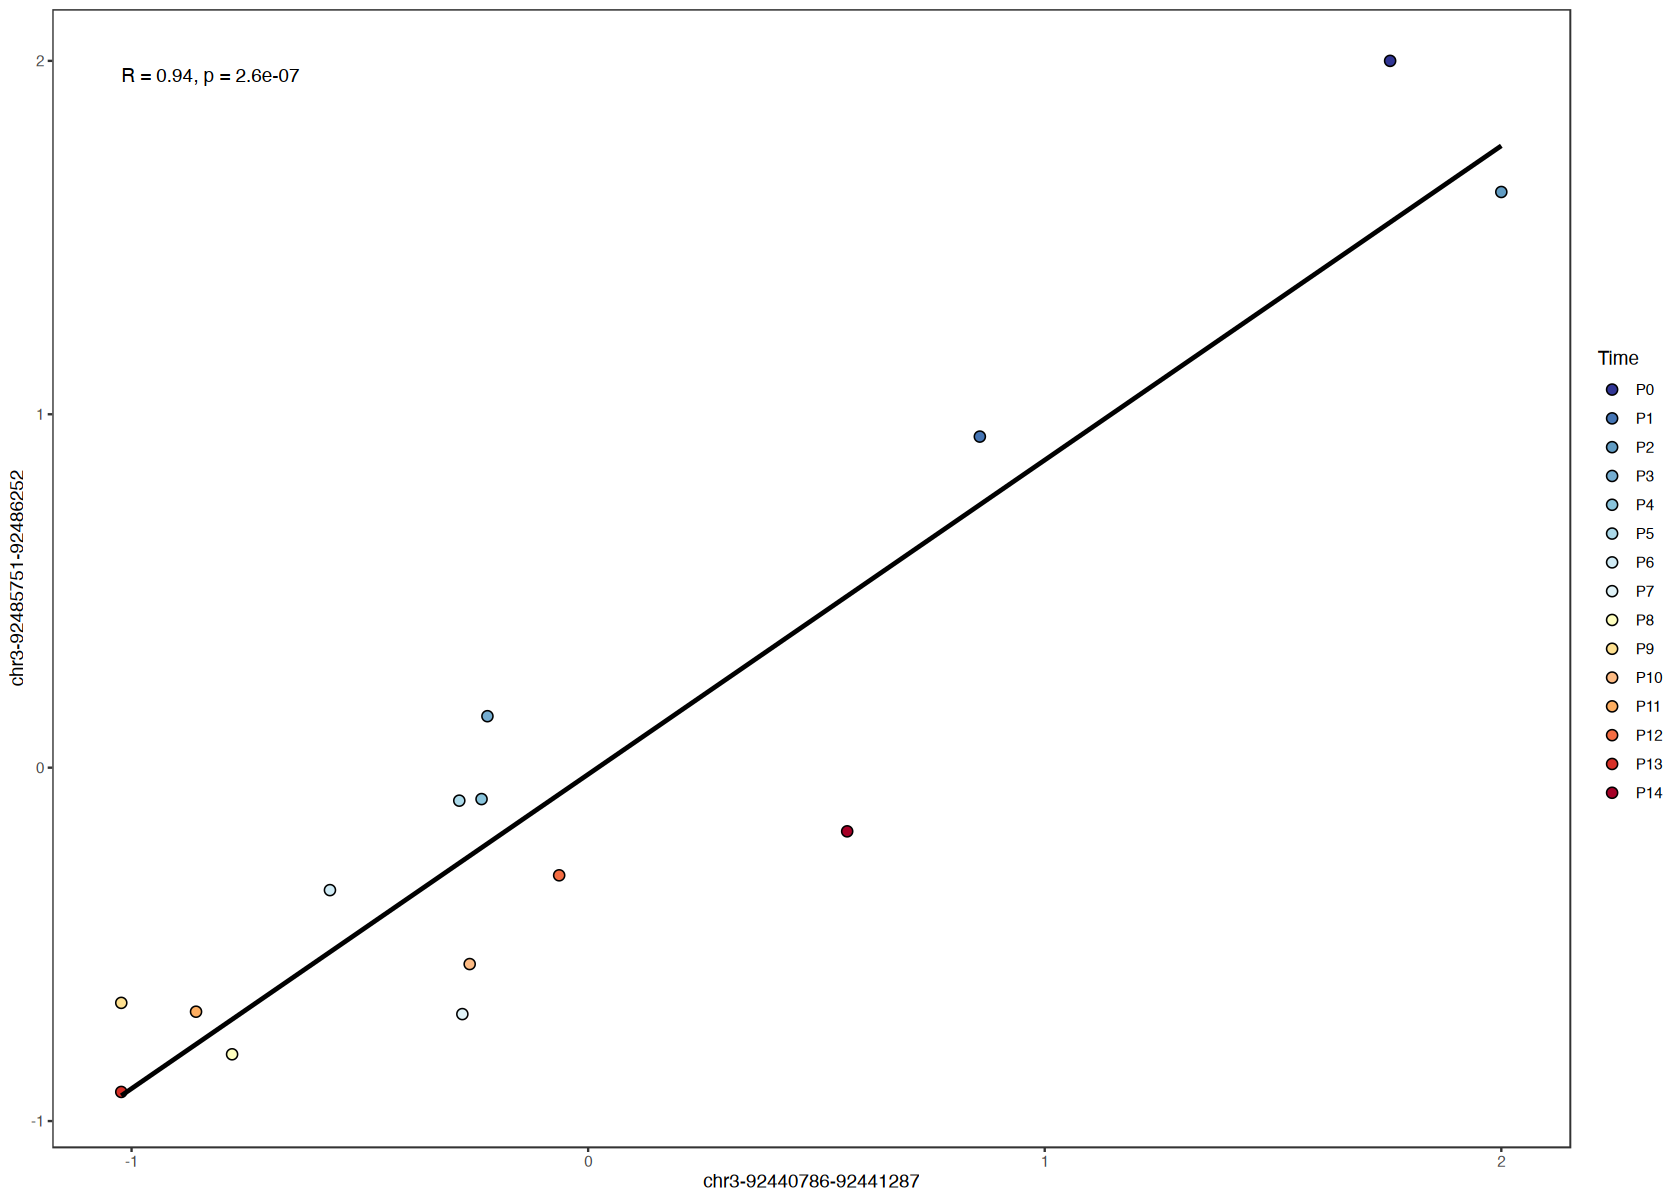

In [233]:
tmp_df = t(cre_acces_pseudo_raw[c('chr3-92440786-92441287','chr3-92485751-92486252'), pesutotime_levels])
tmp_df = as.data.frame(tmp_df)
tmp_df$Time = rownames(tmp_df)
a=tmp_df %>%
    mutate(Time=factor(Time, levels=pesutotime_levels)) %>%
    ggplot(aes(x=`chr3-92440786-92441287`, y=`chr3-92485751-92486252`))+
    geom_point(aes(fill=Time),shape=21, size=2.5)+
    geom_smooth(method='lm', se=F, color='black')+
    stat_cor(method = 'pearson', label.x.npc = 'left', label.y.npc = 'top')+
    scale_fill_manual(values=time_color2)+
    theme_bw()+
    theme(panel.grid = element_blank())
a
ggsave(glue('{output_dir}/AT1_networkTop2CREcorrelation.pdf'), a,
       width=80, height=60, units='mm', dpi=600, bg='transparent')

In [14]:
Fragments(srt) = NULL

Fragments(srt) = myfragments

In [168]:
Idents(srt) = factor(srt$Time, levels = time_levels)

In [294]:
srt[['stage']] = 'stage1'
srt@meta.data[as.vector(srt$Time) %in% c('P4','P5','P6','P7','P8','P9','P10','P11'),'stage']= 'stage2'
srt@meta.data[as.vector(srt$Time) %in% c('P12','P13','P14'),'stage']= 'stage3'

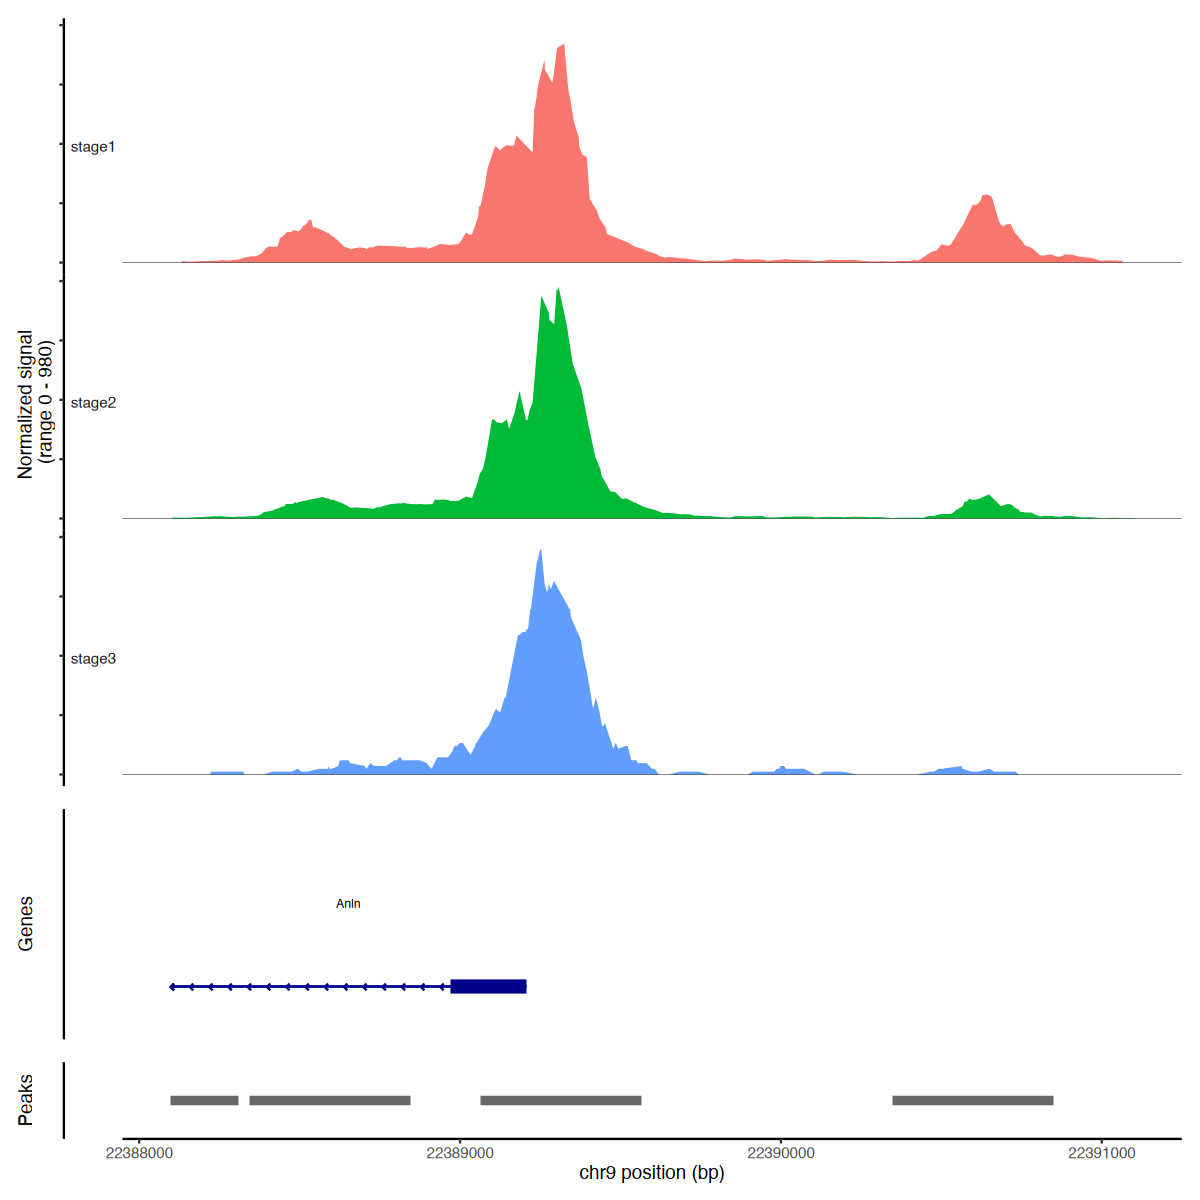

In [295]:
options(repr.plot.width=10, repr.plot.height=10)
a=CoveragePlot(srt, 
               region = cre_order[1],
               group.by = 'stage',
               extend.upstream = 2250,
               extend.downstream = 250
              )
a
ggsave(glue('{output_dir}/AT1_CRE_top1_coverage.pdf'), a,
       width=100, height=60, units='mm', dpi=600, bg='transparent')

In [10]:
head(srt@meta.data)

orig.ident    nCount_ATAC nFeature_ATAC sampleID
AS240819_AAACCAGGTCACCAAT-4  SeuratProject 0           0             AS240819
AS240819_AAACCGGTCAGCTATT-43 SeuratProject 0           0             AS240819
AS240819_AAACCGGTCGCTAATT-46 SeuratProject 0           0             AS240819
AS240819_AAACGAACAGAGAGCA-13 SeuratProject 0           0             AS240819
AS240819_AAACGGGCAAGGTATT-13 SeuratProject 0           0             AS240819
AS240819_AAACGGTTCTTTAAGC-43 SeuratProject 0           0             AS240819
                             X                            sample   leiden_0.1
AS240819_AAACCAGGTCACCAAT-4  AS240819_AAACCAGGTCACCAAT-4  AS240819 6         
AS240819_AAACCGGTCAGCTATT-43 AS240819_AAACCGGTCAGCTATT-43 AS240819 6         
AS240819_AAACCGGTCGCTAATT-46 AS240819_AAACCGGTCGCTAATT-46 AS240819 6         
AS240819_AAACGAACAGAGAGCA-13 AS240819_AAACGAACAGAGAGCA-13 AS240819 6         
AS240819_AAACGGGCAAGGTATT-13 AS240819_AAACGGGCAAGGTATT-13 AS240819 6         
AS240819_AAACGGTTCTTTAAGC-43 AS240819_AAACGGTTCTTTAAGC-43 AS240819 6         
                             leiden_0.2 leiden_0.3 leiden_0.4 ⋯ nCount_CRE
AS240819_AAACCAGGTCACCAAT-4  6          6          6          ⋯ 2467      
AS240819_AAACCGGTCAGCTATT-43 6          6          6          ⋯ 3011      
AS240819_AAACCGGTCGCTAATT-46 6          6          6          ⋯ 1809      
AS240819_AAACGAACAGAGAGCA-13 6          6          6          ⋯ 1301      
AS240819_AAACGGGCAAGGTATT-13 6          6          6          ⋯  583      
AS240819_AAACGGTTCTTTAAGC-43 6          6          6          ⋯  953      
                             nFeature_CRE CRE_snn_res.0.8 seurat_clusters Time
AS240819_AAACCAGGTCACCAAT-4  2347         5               1               P5  
AS240819_AAACCGGTCAGCTATT-43 2845         1               1               P5  
AS240819_AAACCGGTCGCTAATT-46 1719         0               1               P5  
AS240819_AAACGAACAGAGAGCA-13 1238         3               1               P5  
AS240819_AAACGGGCAAGGTATT-13  564         4               1               P5  
AS240819_AAACGGTTCTTTAAGC-43  914         0               1               P5  
                             Celltype_round2 Celltype_round3 Time_num
AS240819_AAACCAGGTCACCAAT-4  AT1             AT1             5       
AS240819_AAACCGGTCAGCTATT-43 AT1             AT1             5       
AS240819_AAACCGGTCGCTAATT-46 AT1             AT1             5       
AS240819_AAACGAACAGAGAGCA-13 AT1             AT1             5       
AS240819_AAACGGGCAAGGTATT-13 AT1             AT1             5       
AS240819_AAACGGTTCTTTAAGC-43 AT1             AT1             5       
                             CRE_snn_res.0.2 pseudotime
AS240819_AAACCAGGTCACCAAT-4  1               0.8698697 
AS240819_AAACCGGTCAGCTATT-43 1               0.8390909 
AS240819_AAACCGGTCGCTAATT-46 1               0.8619844 
AS240819_AAACGAACAGAGAGCA-13 1               0.8758693 
AS240819_AAACGGGCAAGGTATT-13 1               0.8683283 
AS240819_AAACGGTTCTTTAAGC-43 1               0.8667694

In [23]:
table(srt$Celltype_round4)/ ncol(srt)


       AT1    AT1_Agt   AT1_Mfrp  AT1_Nek10  AT1_Tldc2 
0.31318730 0.15370288 0.18708091 0.25474594 0.09128297 

In [ ]:
CodePath = glue('{base_dir}/ATAC_pipeline_zyr/Code/')
source(file.path(CodePath,'Function/Co_accessibility.R'))

peakToPeak.list = CalculateCoAccConSelf(srt, 'CRE', genome = c('chr3'))


tmp_conns = peakToPeak.list$conns
tmp_conns = tmp_conns[(tmp_conns$Peak1==selec_cre) | (tmp_conns$Peak2==selec_cre),]
links.gr <- ConnectionsToLinks(conns = tmp_conns, ccans = peakToPeak.list$CCANs)

Links(srt) <- links.gr#peakToPeak.list$links.gr

In [329]:
cre_order[2]

[1] "chr3-92440786-92441287"

In [349]:
aa[aa$gene_name=='Sprr1b']

GRanges object with 1 range and 6 metadata columns:
                     seqnames            ranges strand |            gene_id
                        <Rle>         <IRanges>  <Rle> |        <character>
  ENSMUSG00000048455        3 92436809-92438789      - | ENSMUSG00000048455
                       gene_name   gene_biotype seq_coord_system      symbol
                     <character>    <character>      <character> <character>
  ENSMUSG00000048455      Sprr1b protein_coding       chromosome      Sprr1b
                     entrezid
                       <list>
  ENSMUSG00000048455    20754
  -------
  seqinfo: 22 sequences (1 circular) from GRCm38 genome

In [334]:
srt@assays$CRE@meta.features[,'peak_group'] = 'unlink'
srt@assays$CRE@meta.features[c(cre_order[2],'chr3-92485751-92486252'),'peak_group'] = 'link'

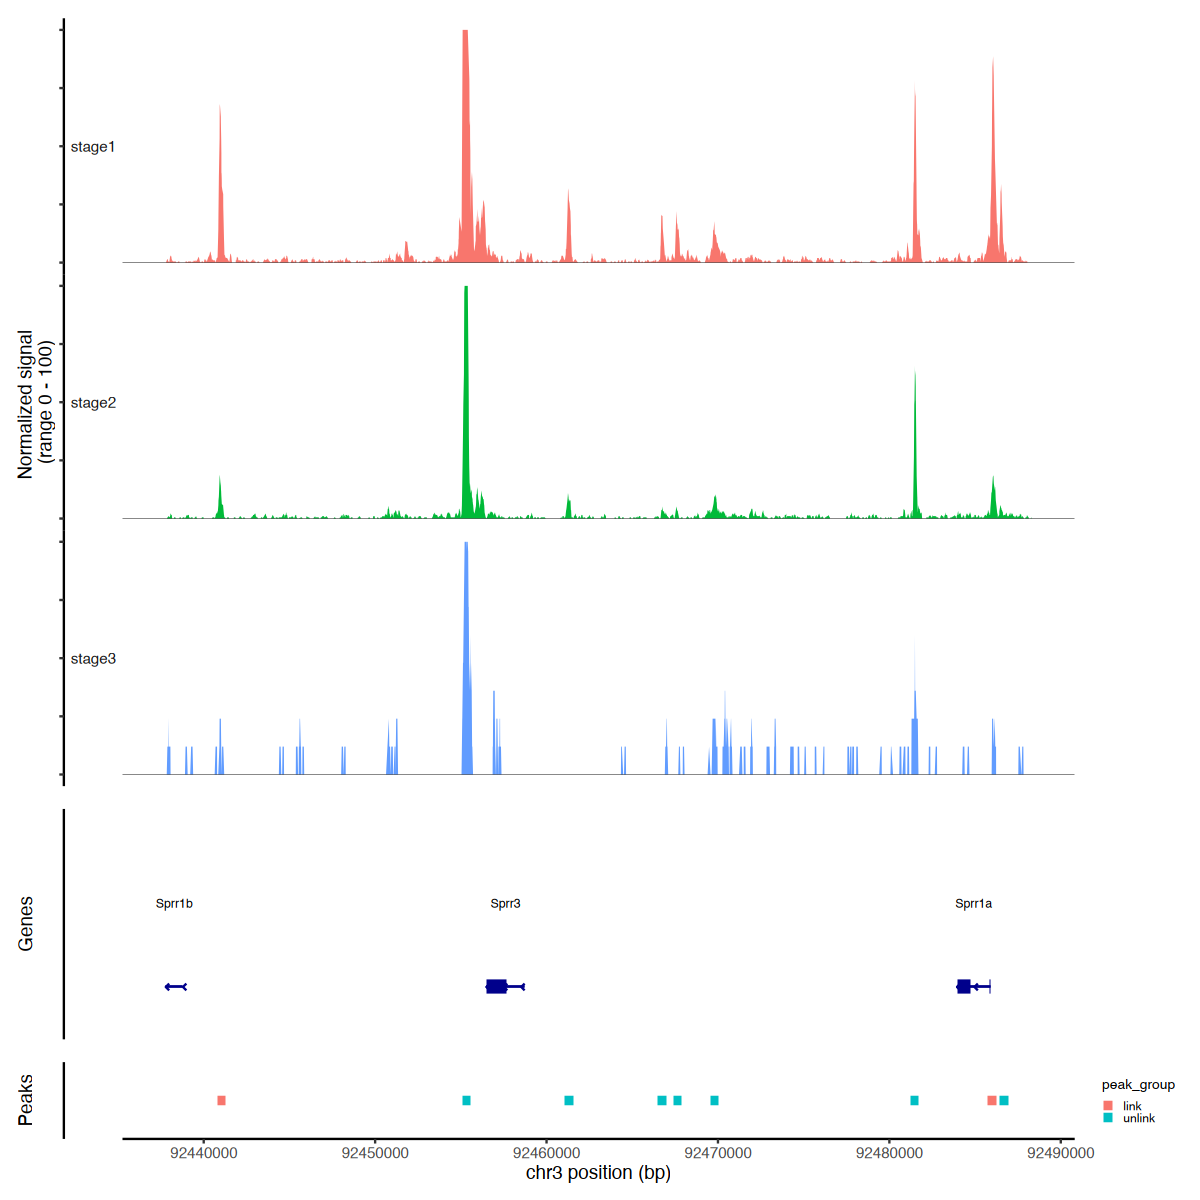

In [336]:
options(repr.plot.width=10, repr.plot.height=10)
a=CoveragePlot(srt, 
               region = cre_order[2],
               group.by = 'stage',
               ymax=100,
               extend.upstream = 3000,
               extend.downstream = 47000,
               peaks.group.by='peak_group'
              )
a
ggsave(glue('{output_dir}/AT1_CRE_top2_coverage.pdf'), a,
       width=120, height=80, units='mm', dpi=600, bg='transparent')

In [313]:
selec_cre=cre_order[1]
gene_body_matrix_sub = readRDS('./placeholder_analysis/round_cluster02/merge/AT1_gene_matrix_enhance2.rds')
srt[["GeneACCen1"]]=NULL
srt[["GeneACCen1"]] = CreateAssayObject(gene_body_matrix_sub,key = 'GeneACCen1')

meanACC_pseudo = myAveragePeak(srt, 'Time', assay="GeneACCen1", slot='data')
#meanACC_pseudo = log2(meanACC_pseudo+1)
meanACC_pseudo = as.matrix(meanACC_pseudo)
meanACC_pseudo = myRowScale(meanACC_pseudo, max = 2, min = -2,limit=TRUE)

meanACC_pseudo_melt = melt(meanACC_pseudo)
colnames(meanACC_pseudo_melt) = c('Gene', 'Time', 'GeneActivity')

In [314]:
meanACC_pseudo_melt$CRE_acc = cre_acces_pseudo_raw[selec_cre, meanACC_pseudo_melt$Time, drop=T]

`geom_smooth()` using formula = 'y ~ x'


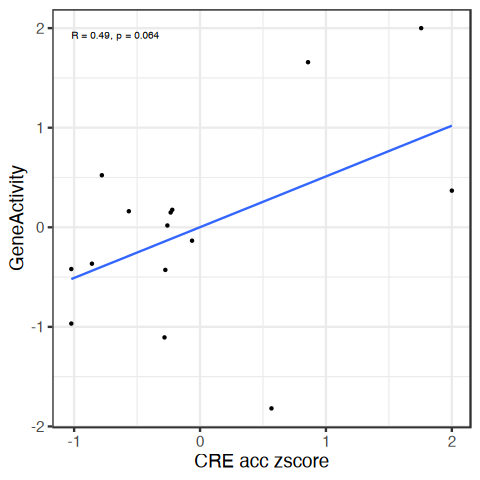

In [326]:
options(repr.plot.width=4, repr.plot.height=4)
a=meanACC_pseudo_melt %>%
    filter(Gene=='Anln') %>%
    ggplot(aes(x=CRE_acc, y=GeneActivity))+
    geom_point(size=0.2)+
    geom_smooth(se=F, method='glm', size=0.5)+
    stat_cor(size=2)+
    labs(x='CRE acc zscore')+
    #facet_wrap(~Gene, ncol=3)+
    theme_bw()
a

In [324]:
ggsave(glue('{output_dir}/AT1_AnlnandTF_correlation.pdf'), a,
       width=40, height=40, units='mm', dpi=600, bg='transparent')

`geom_smooth()` using formula = 'y ~ x'


In [235]:
selec_cre=cre_order[2]

In [236]:
gene_body_matrix_sub = readRDS('./placeholder_analysis/round_cluster02/merge/AT1_gene_matrix_enhance1.rds')
srt[["GeneACCen1"]]=NULL
srt[["GeneACCen1"]] = CreateAssayObject(gene_body_matrix_sub,key = 'GeneACCen1')

meanACC_pseudo = myAveragePeak(srt, 'Time', assay="GeneACCen1", slot='data')
#meanACC_pseudo = log2(meanACC_pseudo+1)
meanACC_pseudo = as.matrix(meanACC_pseudo)
meanACC_pseudo = myRowScale(meanACC_pseudo, max = 2, min = -2,limit=TRUE)

meanACC_pseudo_melt = melt(meanACC_pseudo)
colnames(meanACC_pseudo_melt) = c('Gene', 'Time', 'GeneActivity')


In [238]:
meanACC_pseudo_melt$CRE_acc = cre_acces_pseudo_raw[selec_cre, meanACC_pseudo_melt$Time, drop=T]


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


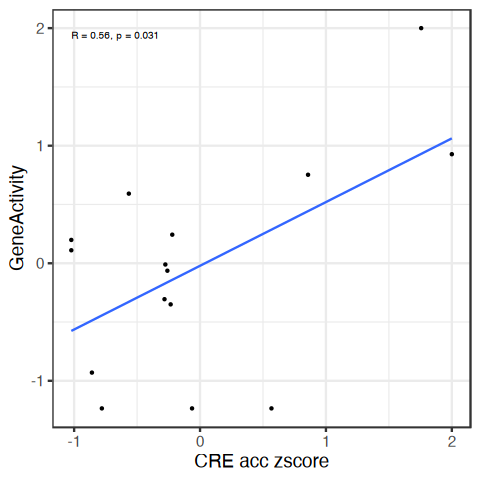

In [320]:
options(repr.plot.width=4, repr.plot.height=4)
a=meanACC_pseudo_melt %>%
    filter(Gene=='Sprr1a') %>%
    ggplot(aes(x=CRE_acc, y=GeneActivity))+
    geom_point(size=0.2)+
    geom_smooth(se=F, method='glm', size=0.5)+
    stat_cor(size=2)+
    labs(x='CRE acc zscore')+
    #facet_wrap(~Gene, ncol=3)+
    theme_bw()
a
ggsave(glue('{output_dir}/AT1_EnhandTF_correlation.pdf'), a,
       width=40, height=40, units='mm', dpi=600, bg='transparent')

In [ ]:
tmp_df = t(cre_acces_pseudo_raw[c('chr3-92440786-92441287','chr3-92485751-92486252'), pesutotime_levels])
tmp_df = as.data.frame(tmp_df)
tmp_df$Time = rownames(tmp_df)
a=tmp_df %>%
    mutate(Time=factor(Time, levels=pesutotime_levels)) %>%
    ggplot(aes(x=`chr3-92440786-92441287`, y=`chr3-92485751-92486252`))+
    geom_point(aes(fill=Time),shape=21, size=2.5)+
    geom_smooth(method='lm', se=F, color='black')+
    stat_cor(method = 'pearson', label.x.npc = 'left', label.y.npc = 'top')+
    scale_fill_manual(values=time_color2)+
    theme_bw()+
    theme(panel.grid = element_blank())
a
ggsave(glue('{output_dir}/AT1_networkTop2CREcorrelation.pdf'), a,
       width=80, height=60, units='mm', dpi=600, bg='transparent')

`geom_smooth()` using formula = 'y ~ x'


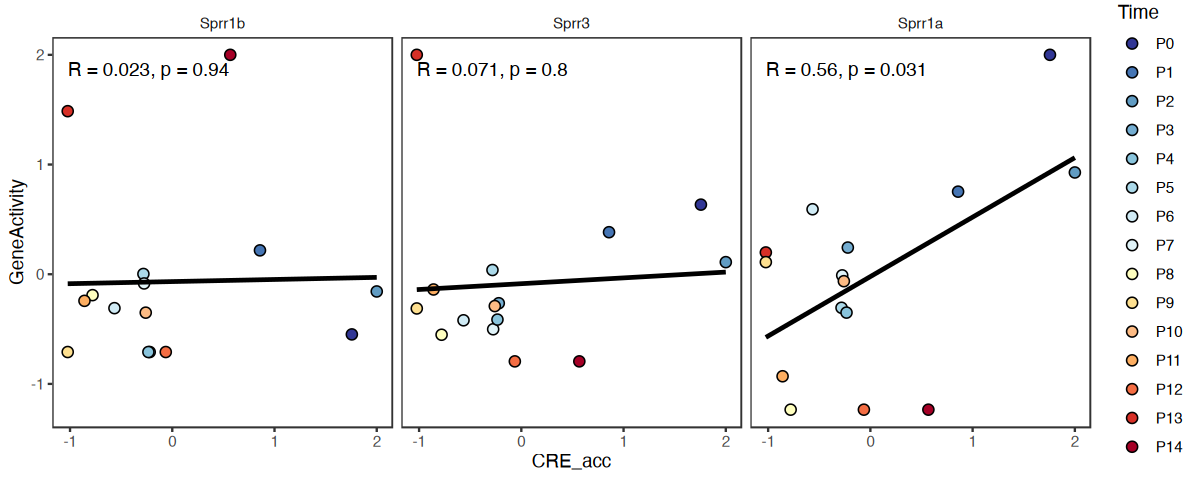

In [243]:
options(repr.plot.width=10, repr.plot.height=4)
a = meanACC_pseudo_melt %>%
    mutate(Time=factor(Time, levels=pesutotime_levels)) %>%
    ggplot(aes(x=CRE_acc, y=GeneActivity))+
    geom_point(aes(fill=Time),shape=21, size=2.5)+
    geom_smooth(method='lm', se=F, color='black')+
    facet_wrap(~Gene, ncol=3)+
    stat_cor(method = 'pearson', label.x.npc = 'left', label.y.npc = 'top')+
    scale_fill_manual(values=time_color2)+
    theme_bw()+
    theme(panel.grid = element_blank(),
        strip.background = element_blank())
a

In [246]:
ggsave(glue('{output_dir}/AT1_CRE_top2_cor.pdf'), a,
       width=190, height=80, units='mm', dpi=600, bg='transparent')

`geom_smooth()` using formula = 'y ~ x'
